### Итоговое задание Александра Соколова
### по Проекту 8. Возьмёте Бэтмобиль? 
####    Юнит 9. NLP/Computer Vision  (отредактирован 17.02.2021)
####    Это приложение к основному ноутбуку содержит разведовательный анализ (EDA) и препроцессинг табличных данных
---

# 1. Импорты библиотек, инициализация глобальных констант, контроль инициализации пакетов и оборудования
## 1.1. Импорты библиотек

In [665]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import math
import sys
import random as rn
# import pandas_profiling
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_classif, mutual_info_classif
from itertools import combinations
from scipy.stats import ttest_ind

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.19.4


In [666]:
import utils_module06022021_without_GPU as utils

## 1.2. Глобальные константы

In [667]:
CURRENT_DIR = './'  # имя текущей директории для локальной машины 
# CURRENT_DIR = '../'  # имя текущей директории для каггл

# проверка пути в папке input для корректного назначения глобальной константы PATH_TO_FILE
print(os.listdir(CURRENT_DIR+'input/'))

['sf-dst-car-price-prediction-part2', 'module8']


In [668]:
PATH_to_FILE = CURRENT_DIR+'input/sf-dst-car-price-prediction-part2/'  # имя директории с исходными файлами
PATH_to_WORKDIR = CURRENT_DIR+'working/'  # имя рабочей директории

RANDOM_SEED = 42  # фиксируем состояние генератора псевдо-случайных чисел для воспроизводимости результата
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(RANDOM_SEED)

!pip3 freeze > requirements.txt  # фиксируем версии всех пакетов для воспроизводимости результата

CURRENT_DATE = dt.now().strftime('[%d.%m.%Y]')  # фиксируем текущую дату для контроля версий экспериментов

# 2. Импорт и предобработка данных
## 2.1. Импорт данных

In [669]:
df_train = pd.read_csv(PATH_to_FILE + 'train.csv')
df_test = pd.read_csv(PATH_to_FILE + 'test.csv')
df_submit = pd.read_csv(PATH_to_FILE + 'sample_submission.csv')

pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))

Размерность тренировочного датасета:  (6682, 22)


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый


In [670]:
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тестового датасета:  (1671, 21)


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый


In [671]:
print('Размерность датасета c примером сабмишена: ', df_submit.shape)
display(df_submit.head(2))

Размерность датасета c примером сабмишена:  (1671, 2)


,sell_id,price
0,1099427284,0
1,1096405886,0


### 2.2. Слияние датасетов в один

In [672]:
# сравним датасеты перед слиянием
utils.check_df_before_merg(df_train, df_test)

,# уник_1,в первой строке_1,тип_1,имя признака_1,имя признака_2,тип_2,в первой строке_2,# уник_2
0,17,седан,object,bodyType,bodyType,object,универсал 5 дв.,14.0
1,3,BMW,object,brand,brand,object,MERCEDES,3.0
2,16,чёрный,object,color,color,object,чёрный,15.0
3,6147,Авто на бодром ходу. Все работает отлично. П...,object,description,description,object,Всем привет!\n\nПродам эксклюзивный проект 124...,1540.0
4,48,3.0 LTR,object,engineDisplacement,engineDisplacement,object,3.0 LTR,43.0
5,146,272 N12,object,enginePower,enginePower,object,220 N12,120.0
6,4,бензин,object,fuelType,fuelType,object,бензин,4.0
7,2900,245000,int64,mileage,mileage,int64,350000,935.0
8,41,2007,int64,modelDate,modelDate,int64,1984,37.0
9,118,5ER,object,model_info,model_info,object,W124,101.0


Резюме:
 1. Не совпали типы в:= 1 столбцах

2. Уникальные значения заоблачно различаются в:= 3 столбцах [3, 7, 14]


,имя признака_1,не совпадают типы,имя признака_2
index,,,
12,price,float64!=nan,NaN


In [673]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

# 3. Предварительный анализ данных

In [674]:
# анализ тренировочной части
# pandas_profiling.ProfileReport(df[df['Train']==1])

In [675]:
# анализ валидационной части
# pandas_profiling.ProfileReport(df[df['Train']==0])

In [676]:
# выведем сводную информацию по датасету df без теста kaggle
utils.describe_without_plots_all_collumns(df[df['Train']==1], short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,bodyType,object,6682,0,17,NaN,NaN,NaN,NaN
1,brand,object,6682,0,3,NaN,NaN,NaN,NaN
2,color,object,6682,0,16,NaN,NaN,NaN,NaN
3,description,object,6682,0,6147,NaN,NaN,NaN,NaN
4,engineDisplacement,object,6682,0,48,NaN,NaN,NaN,NaN
5,enginePower,object,6682,0,146,NaN,NaN,NaN,NaN
6,fuelType,object,6682,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,6682,0,2900,1,120523,999999,111000
8,modelDate,int64,6682,0,41,1975,2010.14,2019,2011
9,model_info,object,6682,0,118,NaN,NaN,NaN,NaN


In [677]:
# выведем сводную информацию по тесту
utils.describe_without_plots_all_collumns(df[df['Train']==0], short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,bodyType,object,1671,0,14,NaN,NaN,NaN,NaN
1,brand,object,1671,0,3,NaN,NaN,NaN,NaN
2,color,object,1671,0,15,NaN,NaN,NaN,NaN
3,description,object,1671,0,1540,NaN,NaN,NaN,NaN
4,engineDisplacement,object,1671,0,43,NaN,NaN,NaN,NaN
5,enginePower,object,1671,0,120,NaN,NaN,NaN,NaN
6,fuelType,object,1671,0,4,NaN,NaN,NaN,NaN
7,mileage,int64,1671,0,935,1,119725,1e+06,109000
8,modelDate,int64,1671,0,37,1971,2009.98,2019,2011
9,model_info,object,1671,0,101,NaN,NaN,NaN,NaN


Резюме по предварительному анализу: (выводы идут по порядку выявления, а не по значимости)  
В тренировочной выборке 6682 строк, в тестовой 1671. Всего - 8353 строк. Всего 23 признака, из них: 
  - 5 - числовых - mileage, modelDate, productionDate, numberOfDoors, sell_id (sell_id- сервисный признак)  
  - 17 - категориальных - пока так, во время анализа, вероятно, какие-нибудь из них станут числовыми  
  - 1 - бинарный - Train  - сервисный для разделения train и test
  
Детальная информация по трейну и тесту:  
- характерно для теста и трейна:
  - руль - очень уникальный признак почти все значения "левый руль", только 2 строки из 6682 - выбросы "правый руль"  => надо еще внимательно посмотреть на этапе анализа - удалить выбросы, а потом удалить признак
  - высокая корреляция между modelDate и productionDate => надо еще внимательно посмотреть на этапе анализа
  - высокая корреляция между  numberOfDoors и bodyType => надо еще внимательно посмотреть на этапе анализа
  - между vehicleConfiguration и еще 2-мя признаками: vehicleTransmission, engineDisplacement - высокая корреляция => надо проверить это при анализе и при необходимости удалить  
  - sell_id хоть и сервисный признак, но в нем наблюдается сильный перекос в данных (вероятно из-за того что датасет формировался в разное время или разными способоми, надо обратить на это внимание во время EDA)   

- по трейну:
  - в трейне нет дубликатов по строкам
  - пропуски в трейне:
    - Владение - 4326 (64.7%) => очень много пропусков надо попробовать заполнить, если не получится, тогда удалить
    - Владельцы - 1(< 0.1%) => один пропуск, надо попробовать заполнить

- по тесту:    
  - пропуски в тесте:
    - Владение - 1092 (65.4%) => очень много пропусков надо попробовать заполнить, если не получится, тогда удалить
    - price - 1671 (100.0%) 

Описания полей датасета:
- bodyType - тип кузова автомобиля (https://ru.wikipedia.org/wiki/Типы_автомобильных_кузовов)
- brand - марка (бренд) автомобиля
- color	- цвет автомобиля (16 цветов: чёрный, красный, синий, серебристый, зелёный, белый, серый, голубой, пурпурный, коричневый, золотистый, фиолетовый, жёлтый, оранжевый, розовый)
- description - дополнительные характеристики по комплектации авто
- engineDisplacement - объем двигателя в литрах
- enginePower - мощность двигателя (л.с.)
- fuelType - тип топлива (5 видов топлива: бензин, дизель, электро, гибрид, газ)
- mileage - пробег автомобиля (км.) - представляет собой общее количество километров, которое это транспортное средство проехало по дорогам с момента своего схода с конвейера производителя. 
- modelDate - дата (год) выпуска модели (!!!внимание!!! не путать с датой производства)
- model_info - информация о классе автомобиля или марке
- name - комбинация нескольких характеристик (модели, объема двигателя и привода)
- numberOfDoors - кол-во дверей
- price - цена указанная в объявлении на авто.ру
- productionDate - дата (год) производства авто
- sell_id - сервисный признак для генерации submition, а также для обращения к фото авто
- vehicleConfiguration - комбинация типа трансмиссии, объема двигателя и мощности двигателя
- vehicleTransmission - тип трансмиссии (коробки передач) (4 вида: автоматическая, механическая, роботизированная, вариатор)
- Владельцы - кол-во владельцев (3 значения: 1 владелец, 2 владельца, 3 и более)
- Владение - срок владения автомобилем в годах и месяцах
- ПТС - тип ПТС (паспорт технического средства)(2 значения - оригинал, дубликат)
- Привод - характеристика привода автомобиля, которое передает энергию от двигателя на колеса. Переднеприводные автомобили получают всю энергию двигателя на передние колеса. При заднем приводе энергия двигателя целиком поступает на задние колеса. Когда энергия двигателя передается на все четыре колеса автомобиля, такой привод является полным ('полный', 'передний', 'задний')
- Руль - характеристика руля по стороне расположения руля в автомобиле (Левый, Правый)
- Train - сервисный признак для разделения train и test

In [678]:
# внесем данные по типам переменных из резюме в списки 

# бинарная переменная (0) Train внесем в список сервисных
bin_cols = []
# категориальные переменные (17), (Руль пока уставляем так как надо избавится от выбросов)
cat_cols = ['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'model_info', 'name',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль']
# числовые переменные (4) sell_id внесем в список сервисных
num_cols = ['mileage', 'modelDate', 'productionDate', 'numberOfDoors']
# сервисные переменные (2)
servis_cols = ['Train', 'sell_id']
# целевая переменная (1)
target_col = ['price']
# итого 0+16+4+2+1=28

all_cols =cat_cols + num_cols + servis_cols + bin_cols + target_col
print(f'Кол-во признаков, для дальнейшей работы после предварительного анализа:= {len(all_cols)}')
print(f'Кол-во сервисных признаков:= {len(servis_cols)}')
print(f'Кол-во сервисных признаков для разведовательного анализа (EDA):= {len(all_cols)-len(servis_cols)}')

Кол-во признаков, для дальнейшей работы после предварительного анализа:= 23
Кол-во сервисных признаков:= 2
Кол-во сервисных признаков для разведовательного анализа (EDA):= 21


In [679]:
old_len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне до EDA:= ', old_len_train)

Кол-во строк в трейне до EDA:=  6682


# 4. Детальный разведовательный анализ по переменным (EDA)
---
## 4.1 bodyType

In [680]:
# так как признаков много создаем список проанализированных признаков, чтобы можно было посмотреть, что осталось сделать  
EDA_done_cols=[]

In [681]:
df = utils.auto_eda_cat_col('bodyType',
                            'тип кузова',
                            df)

EDA по категориальному признаку:= bodyType (тип кузова)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 17
===
КУЗ в трейне:= 17
КУЗ в тесте:= 14
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'седан', 'хэтчбек 3 дв.', 'универсал 5 дв.', 'компактвэн', 'купе', 'лимузин', 'внедорожник открытый', 'седан 2 дв.', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'пикап двойная кабина', 'внедорожник 3 дв.', 'кабриолет', 'лифтбек', 'купе-хардтоп', 'минивэн', 'родстер'}
СУЗ в тесте:=  {'седан', 'универсал 5 дв.', 'купе', 'внедорожник открытый', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп', 'внедорожник 3 дв.', 'пикап двойная кабина', 'кабриолет', 'лифтбек', 'хэтчбек 3 дв.', 'минивэн', 'родстер'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= {'лимузин', 'компактвэн', 'седан 2 дв.'}
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===

Кол-во строк критерия тип кузова=='лимузин' в трейне := 5     (0.07% от трейна). Рекомендую уд

***Резюме по bodyType:-*** Категориальный признак. Удалили 3 типа кузова как выбросы. Оставили 14 типов кузовов как в тесте, так как типы кузовов отличающиеся от кузовов в тесте очень специфичны и очень сильно влияют на класс автомобиля по которому по общим закономерностям формируется цена, оставим только типы кузова из теста, а потом после EDA проверим достаточно ли большая выборка трейна остается для моделирования или необходимо парсить другие сайты. Пропусков нет.

In [682]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('bodyType', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= bodyType, обработано признаков:= 1, осталось:= 20
Кол-во строк в трейне:=  6668 . Убрали на данном шаге:=  14
Кол-во строк в тесте:=  1671


## 4.2 brand

In [683]:
df = utils.auto_eda_cat_col('brand',
                            'марка автомобиля',
                            df)

EDA по категориальному признаку:= brand (марка автомобиля)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 3
===
КУЗ в трейне:= 3
КУЗ в тесте:= 3
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'AUDI', 'BMW', 'MERCEDES'}
СУЗ в тесте:=  {'AUDI', 'MERCEDES', 'BMW'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= set()
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===
Различий в списках уникальных значений нет.


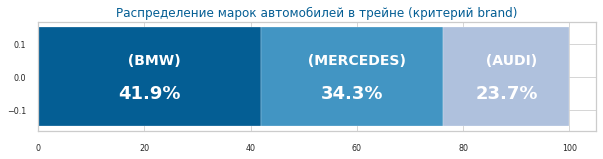

In [684]:
utils.simple_plot_barh_procent('Распределение марок автомобилей в трейне', ['','',''], 'brand',df[df['Train']==1])

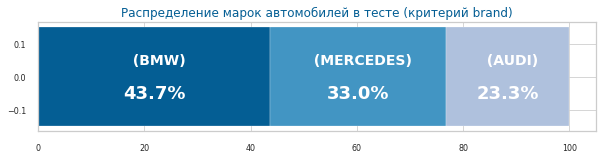

In [685]:
utils.simple_plot_barh_procent('Распределение марок автомобилей в тесте', ['','',''], 'brand',df[df['Train']==0])

***Резюме по brand*** - Категориальный признак. Три уникальных значения - AUDI, MERCEDES, BMW. Распределение марок в трейне и в тесте отлично сбалансировано. Распределение марок внутри отличается - BMW(41-43%%), MERCEDES(34-33%%), AUDI(23%). Так AUDI почти в два раза меньше чем BMW. Из этого следует что во время перекрестного анализа признаков, необходимо обратить внимание на распределения по маркам, а также попробовать сформировать валидационную выборки в соответствии с пропорциями марок. Рассмотреть вариант обучения моделей по маркам отдельно. Пропусков нет. 

In [686]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('brand', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= brand, обработано признаков:= 2, осталось:= 19
Кол-во строк в трейне:=  6668 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.3 color

In [687]:
df = utils.auto_eda_cat_col('color',
                            'цвет',
                            df)

EDA по категориальному признаку:= color (цвет)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 16
===
КУЗ в трейне:= 16
КУЗ в тесте:= 15
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'бежевый', 'голубой', 'золотистый', 'розовый', 'белый', 'коричневый', 'фиолетовый', 'зелёный', 'жёлтый', 'серый', 'красный', 'чёрный', 'серебристый', 'синий', 'пурпурный', 'оранжевый'}
СУЗ в тесте:=  {'бежевый', 'голубой', 'золотистый', 'белый', 'коричневый', 'фиолетовый', 'зелёный', 'жёлтый', 'серый', 'красный', 'чёрный', 'серебристый', 'синий', 'пурпурный', 'оранжевый'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= {'розовый'}
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===

Кол-во строк критерия цвет=='розовый' в трейне := 1     (0.01% от трейна). Рекомендую удалить.Удаление рекомендованных строк успешно проведено.


***Резюме по color:-*** Категориальный признак. Удалил 1 цвет == розовый как выброс. Оставили 15 цветов как в тесте. Пропусков нет.

In [688]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('color', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= color, обработано признаков:= 3, осталось:= 18
Кол-во строк в трейне:=  6667 . Убрали на данном шаге:=  1
Кол-во строк в тесте:=  1671


## 4.4 engineDisplacement

In [689]:
df = utils.auto_eda_cat_col('engineDisplacement',
                            'объём двигателя',
                            df)

EDA по категориальному признаку:= engineDisplacement (объём двигателя)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 48
===
КУЗ в трейне:= 48
КУЗ в тесте:= 43
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'4.0 LTR', '2.1 LTR', '5.9 LTR', '3.7 LTR', '6.2 LTR', '6.0 LTR', '5.2 LTR', 'undefined LTR', '4.7 LTR', '1.5 LTR', '4.2 LTR', '5.5 LTR', '2.3 LTR', '1.8 LTR', '5.6 LTR', '2.0 LTR', '2.5 LTR', '2.7 LTR', '3.4 LTR', '2.6 LTR', '2.8 LTR', '4.8 LTR', '1.2 LTR', '3.2 LTR', '2.2 LTR', '0.7 LTR', '1.9 LTR', '4.3 LTR', '4.9 LTR', '4.4 LTR', '3.8 LTR', '3.0 LTR', '3.6 LTR', '1.3 LTR', '5.0 LTR', '3.5 LTR', '5.4 LTR', '1.6 LTR', '3.1 LTR', '2.9 LTR', '4.1 LTR', '5.8 LTR', '4.6 LTR', '1.4 LTR', '6.6 LTR', '2.4 LTR', '1.7 LTR', '6.3 LTR'}
СУЗ в тесте:=  {'4.0 LTR', '2.1 LTR', '5.9 LTR', '3.7 LTR', '6.2 LTR', '6.0 LTR', '5.2 LTR', 'undefined LTR', '4.7 LTR', '1.5 LTR', '4.2 LTR', '5.5 LTR', '2.3 LTR', '1.8 LTR', '2.0 LTR', '2.5 LTR', '2.6 LTR', '2.7 LTR', '2.8 LTR', '4.8 

In [690]:
# можно заметить что в списке присутствует не типичное значение 'undefined LTR'
# давайте посмотрим что это за авто (вероятнее всего это электрокары)
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]

temp_df_Train[temp_df_Train['engineDisplacement']=='undefined LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [691]:
# да так и есть, кто-то за нас уже убрал информацию о мощности двигателей электрокаров и подготовил для нас датасет 
# по опыту работы над проектом 6 надо проверить, что в электрокары случайно не попали гибриды с двигателями 0.6-0.8 м3 
# убедимся в этом
temp_df_Train[temp_df_Train['fuelType']=='электро'].engineDisplacement.unique()

array(['undefined LTR'], dtype=object)

In [692]:
# также проверим тест
temp_df_Test[temp_df_Test['fuelType']=='электро'].engineDisplacement.unique()

array(['undefined LTR'], dtype=object)

In [693]:
# прекрасно теперь перейдем к парсингу числовой информации из признака engineDisplacement
# обработаем значения с помощью регулярных выражений найдя значения объема в литра типа 2.0 и переведем их см3 
def pars_num_from_engineDisplacement(row):
    row = str(row)
    temp_pars = re.findall('\d\.\d', row)
    
    if temp_pars == []:
        return None  # мы заполняем None, но очень важно, чтобы у модели была возможность использовать признак электрокара
                  # если тут будет стоят ноль, то какой бы гипотетический коэффициент мы к нему не применяли он все равно
                  # их композиция останется нулем и не будет делать вклад в ценообразование. 
                  # Для этого мы на этапе анализа вида топлива создадим отдельную колонку по электрокарам с единицами и 
                  # таким образом автоматически решим эту проблему. Но важно помнить, что при нормализации и стандартизации
                  # ноль может смещаться и начинать вносить ненужный нам вклад. Поэтому мы ставим None и после нормализации 
                  # и стандартизации мы заполним пропуски средними значениями в зависимости от применяемой нами функции  
    else:
        result_volume_of_engine = int(float(temp_pars[0])*1000)

    return result_volume_of_engine
df['engineDisplacement2'] = df['engineDisplacement'].apply(pars_num_from_engineDisplacement)

In [694]:
# добавим объем двигателя engineDisplacement2 в числовые признаки, а engineDisplacement удалим
cat_cols.remove('engineDisplacement') 
num_cols.append('engineDisplacement2')

In [695]:
# теперь когда признак объем двигателя перешел в разряд числового приступим к его анализу как числового признака
utils.describe_without_plots('engineDisplacement2', df[df['Train']==1].engineDisplacement2)

,engineDisplacement2
кол-во строк,6650
тип значений,float64
кол-во значений,6645
кол-во NaN,5
среднее,2778.34
медиана,2800
мин,700
макс,6600


In [696]:
# минимальные значения соответствуют гибридам, убедимся в этом 
df[df['engineDisplacement2']==700][['brand','fuelType', 'engineDisplacement', 'engineDisplacement2']].head(10)

,brand,fuelType,engineDisplacement,engineDisplacement2
127,BMW,гибрид,0.7 LTR,700.0
857,BMW,гибрид,0.7 LTR,700.0
2905,BMW,гибрид,0.7 LTR,700.0
3082,BMW,гибрид,0.7 LTR,700.0
3651,BMW,гибрид,0.7 LTR,700.0
7827,BMW,гибрид,0.7 LTR,700.0


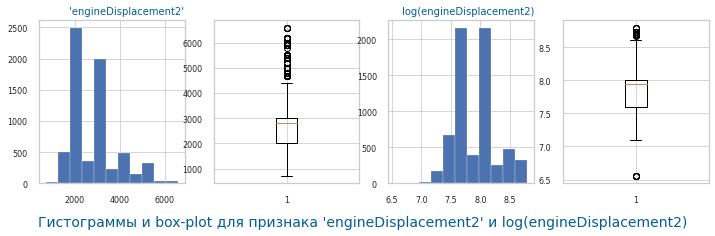

In [697]:
temp_df = df[(df['Train']==1) & (~df['engineDisplacement2'].isna())]
utils.four_plot_with_log2('engineDisplacement2', temp_df)

In [698]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('engineDisplacement2',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,500.0,4500.0
кол-во значений за границей,0.0,547.0


In [699]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('engineDisplacement2',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,6.993455,8.614649
границы выбросов без логарифма,1088.478661,5510.811487
кол-во значений за границей,5.000000,75.000000


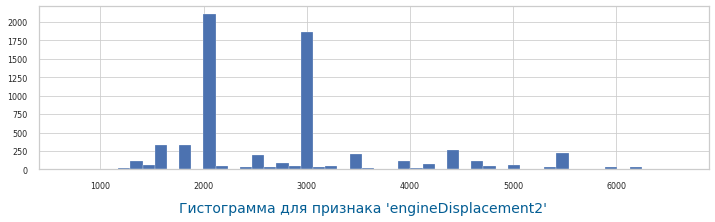

In [700]:
# что-то не нравится мне это зубастое распределение, да и выбросов очень много 
# посмотрим на него поближе
utils.big_hist('engineDisplacement2', temp_df)

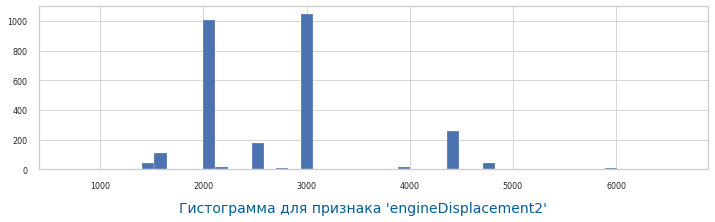

In [701]:
# посмотрим поближе на это распределение в разрезе 3-х брендов
utils.big_hist('engineDisplacement2', temp_df[temp_df['brand']=='BMW'])

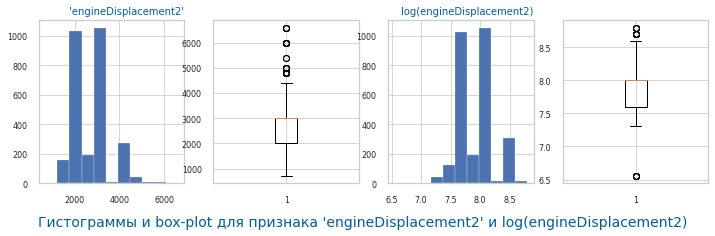

In [702]:
utils.four_plot_with_log2('engineDisplacement2', temp_df[temp_df['brand']=='BMW'])

In [703]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('engineDisplacement2',temp_df[temp_df['brand']=='BMW'], log = False)

,левая,правая
границы выбросов,500.0,4500.0
кол-во значений за границей,0.0,61.0


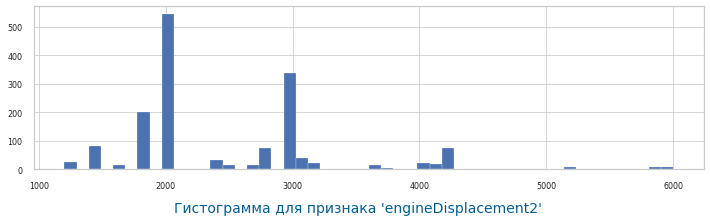

In [704]:
utils.big_hist('engineDisplacement2', temp_df[temp_df['brand']=='AUDI'])

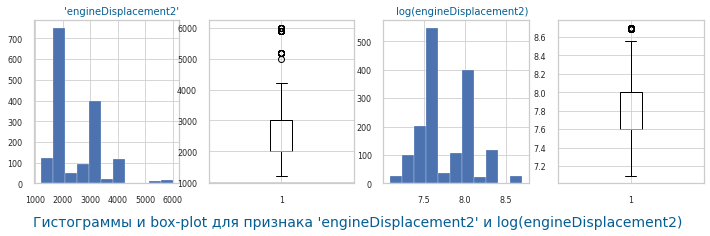

In [705]:
utils.four_plot_with_log2('engineDisplacement2', temp_df[temp_df['brand']=='AUDI'])

In [706]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('engineDisplacement2',temp_df[temp_df['brand']=='AUDI'], log = False)

,левая,правая
границы выбросов,500.0,4500.0
кол-во значений за границей,0.0,28.0


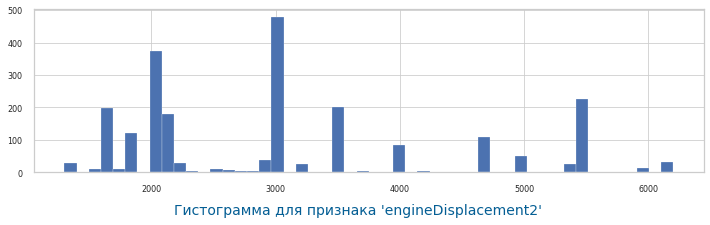

In [707]:
utils.big_hist('engineDisplacement2', temp_df[temp_df['brand']=='MERCEDES'])

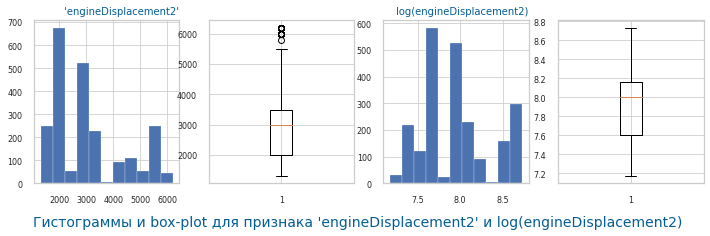

In [708]:
utils.four_plot_with_log2('engineDisplacement2', temp_df[temp_df['brand']=='MERCEDES'])

In [709]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('engineDisplacement2',temp_df[temp_df['brand']=='MERCEDES'], log = False)

,левая,правая
границы выбросов,-250.0,5750.0
кол-во значений за границей,0.0,46.0


In [710]:
46+28+61

135

***Промежуточное резюме:*** Распределения хоть и имеют по отдельности по 3-м брендам форму логнормального распределения и единичные выбросы при логарифмировании, но они имеют достаточно разные средние значения что приводит к тому что сумма трех распределений дает нам 547 выбросов, против всего 135 выбросах по отдельности. Это означает что методам будет сложно в таком виде растянуть общее распределение и применить его в модели, поэтому мы разделим этот признак на три разных признака по моделям, чтобы каждый по отдельности из них был логнормальным с минимальным кол-вом выбросов или вообще без них.   

In [711]:
df['engDisp_AUDI']= df[df['brand']=='AUDI'].engineDisplacement2
df['engDisp_AUDI_log']=df['engDisp_AUDI'].apply(lambda x: np.log(x))

In [712]:
df['engDisp_MERC']= df[df['brand']=='MERCEDES'].engineDisplacement2
df['engDisp_MERC_log']=df['engDisp_MERC'].apply(lambda x: np.log(x))

In [713]:
df['engDisp_BMW']= df[df['brand']=='BMW'].engineDisplacement2
df['engDisp_BMW_log']=df['engDisp_BMW'].apply(lambda x: np.log(x))

In [714]:
# добавим 6 новых признаков объема двигателя и логарифма по брендам в числовые признаки
num_cols.append('engDisp_AUDI')
num_cols.append('engDisp_AUDI_log')
num_cols.append('engDisp_MERC')
num_cols.append('engDisp_MERC_log')
num_cols.append('engDisp_BMW')
num_cols.append('engDisp_BMW_log')

***Резюме по engineDisplacement:-*** Убрали 17 выбросов по несуществующим в тесте объемам двигателей. Спарсили числовые значения и сформировали новый признак объем двигателя в см3. Пропусков в новом признаке - 5. Это пропуски по электрокарам. Заполним после нормализации и стандартизации, чтобы не было смещения от нуля. Распределения скорее логнормальные по форме распределения поэтому сгенерили новые признако с логарифмом. 
Созданы новые числовые признаки:
- 'engineDisplacement2'- объем двигателя в см3
- 'engDisp_AUDI' - объем двигателя по AUDI
- 'engDisp_AUDI_log' - логарифм от объема двигателя по AUDI
- 'engDisp_MERC' - объем двигателя по MERCEDES
- 'engDisp_MERC_log' - логарифм от объема двигателя по MERCEDES
- 'engDisp_BMW' - объем двигателя по BMW
- 'engDisp_BMW_log' - логарифм от объема двигателя по BMW


In [715]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('engineDisplacement', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= engineDisplacement, обработано признаков:= 4, осталось:= 17
Кол-во строк в трейне:=  6650 . Убрали на данном шаге:=  17
Кол-во строк в тесте:=  1671


## 4.5 enginePower

In [716]:
df = utils.auto_eda_cat_col('enginePower',
                            'мощность двигателя',
                            df)

EDA по категориальному признаку:= enginePower (мощность двигателя)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 152
===
КУЗ в трейне:= 144
КУЗ в тесте:= 120
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'507 N12', '223 N12', '610 N12', '143 N12', '230 N12', '313 N12', '256 N12', '571 N12', '296 N12', '113 N12', '575 N12', '250 N12', '265 N12', '600 N12', '435 N12', '316 N12', '190 N12', '445 N12', '299 N12', '370 N12', '422 N12', '329 N12', '326 N12', '557 N12', '184 N12', '238 N12', '558 N12', '239 N12', '517 N12', '525 N12', '279 N12', '612 N12', '234 N12', '170 N12', '609 N12', '347 N12', '272 N12', '360 N12', '500 N12', '163 N12', '306 N12', '407 N12', '115 N12', '225 N12', '252 N12', '118 N12', '555 N12', '204 N12', '249 N12', '200 N12', '136 N12', '129 N12', '125 N12', '258 N12', '100 N12', '455 N12', '116 N12', '340 N12', '520 N12', '585 N12', '469 N12', '174 N12', '402 N12', '110 N12', '140 N12', '255 N12', '218 N12', '560 N12', '122 N12', '544 N12', '

In [717]:
# парсинг числовых значений мощности перед строкой ' N12'
df['enginePower2'] = df['enginePower'].apply(lambda x: int(x.split()[0]))

In [718]:
# добавим мощность двигателя enginePower2 в числовые признаки, а enginePower удалим
cat_cols.remove('enginePower') 
num_cols.append('enginePower2')

In [719]:
# теперь когда признак мощность двигателя перешел в разряд числового приступим к его анализу как числового признака
temp_df_train = df[df['Train']==1]
temp_df_test = df[df['Train']==0]
utils.describe_without_plots('enginePower2', temp_df_train.enginePower2)

,enginePower2
кол-во строк,6546
тип значений,int64
кол-во значений,6546
кол-во NaN,0
среднее,253.839
медиана,230
мин,102
макс,639


In [720]:
# посмотрим на мощность двигателя в тесте 
utils.describe_without_plots('enginePower2', temp_df_test.enginePower2)

,enginePower2
кол-во строк,1671
тип значений,int64
кол-во значений,1671
кол-во NaN,0
среднее,254.646
медиана,231
мин,101
макс,700


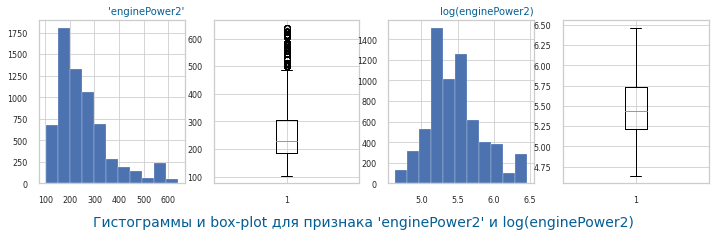

In [721]:
utils.four_plot_with_log2('enginePower2', temp_df_train)

In [722]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('enginePower2', temp_df_train, log = True)

,левая,правая
границы выбросов с логарифмом,4.460618,6.486586
границы выбросов без логарифма,85.540970,655.278756
кол-во значений за границей,0.000000,0.000000


In [723]:
# посмотрим каких авто мощность двигателя в тесте выше максимума на трейне (639)
temp_df_test[temp_df_test['enginePower2']>639]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2
8317,внедорожник 5 дв.,MERCEDES,чёрный,Вашему вниманию предоставляется редкий автомоб...,5.5 LTR,700 N12,бензин,21000,2015,G_KLASSE_AMG,Brabus 700 5.5 AT (700 л.с.) 4WD,5,NaN,2015,1098862906,ALLROAD_5_DOORS AUTOMATIC 5.5,автоматическая,2 владельца,NaN,Оригинал,полный,Левый,0,5500.0,NaN,NaN,5500.0,8.612503,NaN,NaN,700


***Промежуточное резюме:*** Самое мощный авто в тесте аналогов которому нет в трейне - это геленваген 2015 года, в кусочке описания видим слово редкий. Его примерная "не редкая" стоимость порядка 25-28 млн. рублей.  

Давайте оценим на сколько нам можно (не критично) ошибиться в стоимости этого авто:  
 1. По лидерборду видно что 0.001 к скору это критично  
 2. Пусть фактическая стоимость авто 25-28 млн.р.  
 3. n = 1671  

Получаем:  
при 25 млн.р := 0.001/100\*1671\*25000000 := 417750 р   
при 28 млн.р := 0.001/100\*1671\*28000000 := 467880 р  
Это означает что по этому авто можно ошибится как в плюс, так и в минус на примерно 410-470 тыс. рур. и это будет не критично для скорра.  
Поэтому ошибка по этому автомобилю не сильно отразится на MAPE. Надо будет проверить в финале какая по нему назначена стоимость и при необходимости скорректировать

In [724]:
# продолжаем, по форме распределение логнормальное, поэтому сгенерим новый признак логарифма
df['enginePower2_log']=df['enginePower2'].apply(lambda x: np.log(x))

In [725]:
# добавим новый признак логарифма мощности двигателя в числовые признаки
num_cols.append('enginePower2_log')

***Резюме по enginePower:-*** На этапе обработки категориального признака убрали 104 выброса по значениям мощности двигателя, которые не встречаются в тесте. Провели парсинг числовых значений мощности двигателя и создали новый числовой признак. Пропусков нет. По форме распределение скорее логнормальное, без выбросов, поэтому создали еще один признак логарифм мощности двигателя. 

In [726]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('enginePower', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)


В результате после EDA признака:= enginePower, обработано признаков:= 5, осталось:= 16
Кол-во строк в трейне:=  6546 . Убрали на данном шаге:=  104
Кол-во строк в тесте:=  1671


## 4.6 fuelType

In [727]:
df = utils.auto_eda_cat_col('fuelType',
                            'тип топлива',
                            df)

EDA по категориальному признаку:= fuelType (тип топлива)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 4
===
КУЗ в трейне:= 4
КУЗ в тесте:= 4
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'электро', 'бензин', 'дизель', 'гибрид'}
СУЗ в тесте:=  {'электро', 'бензин', 'дизель', 'гибрид'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= set()
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===
Различий в списках уникальных значений нет.


In [728]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]

# Посмотрим на распределение авто по типу топлива в тесте и в трейне
print('Распределение по кол-ву зачений по fuelType в трейне:= \n',temp_df_Train.fuelType.value_counts())
print('Распределение по кол-ву зачений по fuelType в тесте:= \n',temp_df_Test.fuelType.value_counts())

Распределение по кол-ву зачений по fuelType в трейне:= 
 бензин     4693
дизель     1836
гибрид       12
электро       5
Name: fuelType, dtype: int64
Распределение по кол-ву зачений по fuelType в тесте:= 
 бензин     1214
дизель      454
гибрид        2
электро       1
Name: fuelType, dtype: int64


In [729]:
# Посмотрим на пропорции авто по типу топлива в тесте и в трейне
print('Распределение по кол-ву зачений по fuelType в трейне:= \n',temp_df_Train.fuelType.value_counts(normalize=True))
print('Распределение по кол-ву зачений по fuelType в тесте:= \n',temp_df_Test.fuelType.value_counts(normalize=True))

Распределение по кол-ву зачений по fuelType в трейне:= 
 бензин     0.716926
дизель     0.280477
гибрид     0.001833
электро    0.000764
Name: fuelType, dtype: float64
Распределение по кол-ву зачений по fuelType в тесте:= 
 бензин     0.726511
дизель     0.271694
гибрид     0.001197
электро    0.000598
Name: fuelType, dtype: float64


In [730]:
# тест и трейн прекрасно сбалансированы в части пропорций по виду топлива, 
# но нужно учесть, что по гибридам и электрокарам сильная диспропорция внутри типов топлива, 
# поэтому необходимо сформировать валидационную выборку вручную, чтобы сохранить пропорции, 
# или принять решение и по трем авто сделать отдельную модель
# 
# посмотрим какие цены на эти авто чтобы представить их влияние на МАРЕ
temp_df_Train[temp_df_Train['fuelType'].isin(['гибрид','электро'])].price.describe()

count    1.700000e+01
mean     2.462571e+06
std      1.328316e+06
min      9.490000e+05
25%      1.690000e+06
50%      2.190000e+06
75%      2.819000e+06
max      6.000000e+06
Name: price, dtype: float64

In [731]:
temp_df_Train.price.describe()

count    6.546000e+03
mean     1.867704e+06
std      1.840954e+06
min      3.013010e+05
25%      8.000000e+05
50%      1.300000e+06
75%      2.250000e+06
max      2.390000e+07
Name: price, dtype: float64

***Промежуточное резюме:*** Распределения цен гибридов и элетрокаров не сильно отличается по среднему это значит что в среднем цены на них не высоки (1.5-2 млн. р.) по сравнению с рассмотренным выше геленвагеном, поэтому ошибка по ним может дорого нам стоить в МАРЕ, надо подумать как лучше предсказать эти цены на таком дисбалансе. 

Давайте оценим на сколько нам можно (не критично) ошибиться в стоимости по гибридам и электрокарам:  
 1. По лидерборду видно что 0.001 к скору это критично  
 2. Пусть фактическая стоимость авто 1.5-2 млн.р.  
 3. n = 1671  

Получаем:  
при 1.5 млн.р := 0.001/100\*1671\*25000000 := 25065 р   
при 2 млн.р := 0.001/100\*1671\*28000000 := 33420 р  
Это означает что по этим авто можно ошибится как в плюс, так и в минус на примерно 25-34 тыс. рур. и это будет не критично для скорра.  
Поэтому ошибка по этим автомобилям за рамками этих границ сильно отразится на MAPE. Надо будет проверить в финале какая по нему назначена стоимость и при необходимости скорректировать

***Резюме по fuelType:*** - Категориальный признак. 4 значения. Пропусков нет. Электрокаров в трейне - 5, в тесте - 1. Гибридов 12, в тесте - 2. Ранее мы замечали, что необходимо выделить признак элетрокаров, это будет сделано автоматичсеки, когда мы хором обработаем категориальные признаки. 

In [732]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('fuelType', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= fuelType, обработано признаков:= 6, осталось:= 15
Кол-во строк в трейне:=  6546 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.7 model_info

In [733]:
df = utils.auto_eda_cat_col('model_info',
                            'класс или код авто',
                            df)

EDA по категориальному признаку:= model_info (класс или код авто)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 117
===
КУЗ в трейне:= 113
КУЗ в тесте:= 101
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'I3', 'SL_KLASSE', '1ER', 'VIANO', 'RS3', 'A4_ALLROAD', 'Q7', 'X4', 'GLC_KLASSE_AMG', 'R8', 'M_KLASSE_AMG', 'M4', 'GLC_COUPE', 'SLC_KLASSE_AMG', 'X3', 'Q3', 'TTS', 'E_KLASSE_AMG', 'X2', 'Q8', '100', 'M_KLASSE', 'S6', 'GL_KLASSE_AMG', 'GL_KLASSE', 'CLA_KLASSE_AMG', 'SLR_KLASSE', 'GLS_KLASSE', 'E_KLASSE', 'GLK_KLASSE', 'S3', 'RSQ3', 'CLS_KLASSE_AMG', 'M5', 'CLA_KLASSE', 'GLS_KLASSE_AMG', 'TT', 'X1', 'ALLROAD', 'A8', 'SL_KLASSE_AMG', 'GLE_KLASSE', 'X5', 'X6_M', 'A4', 'S_KLASSE_AMG', 'Z1', 'VITO', 'SQ5', 'I8', 'RS6', 'A_KLASSE_AMG', '6ER', 'GLA_CLASS_AMG', 'Z4', 'CLS_KLASSE', 'A6', 'RS5', 'SLC_KLASSE', 'W201', 'S7', 'GLE_KLASSE_COUPE_AMG', 'R_KLASSE', 'SLS_AMG', 'RS4', 'M3', 'A_KLASSE', 'C_KLASSE', 'S_KLASSE', 'A7', 'X5_M', 'G_KLASSE_AMG', '5ER', 'S8', 'CL_KLASSE', 

***Резюме по model_info:*** - Категориальный признак. 117-16=101 значение. Пропусков нет. Удалили выбросы по 16 значениям, которых не было в тесте, это 37 строк. 

In [734]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('model_info', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= model_info, обработано признаков:= 7, осталось:= 14
Кол-во строк в трейне:=  6509 . Убрали на данном шаге:=  37
Кол-во строк в тесте:=  1671


## 4.8 name

In [735]:
# посмотрим на несколько столбцов датасета
df[['brand', 'name', 'engineDisplacement2', 'vehicleTransmission', 'enginePower2', 'Привод']]

,brand,name,engineDisplacement2,vehicleTransmission,enginePower2,Привод
0,BMW,530xi 3.0 AT (272 л.с.) 4WD,3000.0,автоматическая,272,полный
1,AUDI,2.8 CVT (204 л.с.),2800.0,вариатор,204,передний
2,MERCEDES,350 3.5 AT (306 л.с.) 4WD,3500.0,автоматическая,306,полный
3,AUDI,2.0 CVT (180 л.с.),2000.0,вариатор,180,передний
4,AUDI,1.8 CVT (160 л.с.),1800.0,вариатор,160,передний
...,...,...,...,...,...,...
8348,BMW,320i 2.0 AT (184 л.с.),2000.0,автоматическая,184,задний
8349,BMW,25d 3.0d AT (218 л.с.) 4WD,3000.0,автоматическая,218,полный
8350,AUDI,1.4 AMT (150 л.с.),1400.0,роботизированная,150,передний
8351,BMW,520i 2.0 AT (184 л.с.),2000.0,автоматическая,184,задний


In [736]:
# видно что признак name является комбинацией признаков engineDisplacement2, vehicleTransmission, enginePower2, Привод
# но по брендам BMW и MERCEDES перед значением объёма двигателя идет название марки, 
# а у MERCEDES после объема двигателя идет символ (например по индексу 8349 символ d)
# давайте прежде мы его кастрируем до названия модели авто более внимательно посмотрим на него в разрезе брендов
temp_df_BMW = df[df['brand']=='BMW']
temp_df_MERCEDES = df[df['brand']=='MERCEDES']
temp_df_AUDI = df[df['brand']=='AUDI']
temp_df_BMW[['brand', 'name', 'engineDisplacement2', 'fuelType', 'vehicleTransmission', 'enginePower2', 'Привод']].head()

,brand,name,engineDisplacement2,fuelType,vehicleTransmission,enginePower2,Привод
0,BMW,530xi 3.0 AT (272 л.с.) 4WD,3000.0,бензин,автоматическая,272,полный
7,BMW,740Li xDrive 3.0 AT (326 л.с.) 4WD,3000.0,бензин,автоматическая,326,полный
9,BMW,320d xDrive 2.0d AT (184 л.с.) 4WD,2000.0,дизель,автоматическая,184,полный
10,BMW,28i 2.0 AT (245 л.с.) 4WD,2000.0,бензин,автоматическая,245,полный
15,BMW,525i 2.5 AT (218 л.с.),2500.0,бензин,автоматическая,218,задний


In [737]:
# ну не зря мы посмотрели более внимательно, оказалось что по бренду BMW name содержит слово xDrive, которое как мы помним очень важно для определения стоимости авто так как это свой полный привод xDrive отличающийся от обычного наличием электромуфты. На X5 и X6 система xDrive оснащена двумя электромуфтами и без них «противозаносная система» или «система поддержания курсовой устойчивости» (esc,esp) не была реализована даже при наличии обычного полного привода в более ранних моделях. Поэтому очень важно сохранить наличие этого слова как отдельный параметр.
# кроме этого удалось заметить, что символ d это тип топлива 'дизель'
# давайте проверим не осталось ли там между названием модели и объемом двигателя других важных включений
first_set, second_set, third_set = set(), set(), set()
for i in range(len(temp_df_BMW)):
    temp_str = temp_df_BMW.iloc[i]['name']
    volume_engine_str = re.findall('\d\.\d', temp_str)
    if volume_engine_str !=[]:
        ind_str = temp_str.find(volume_engine_str[0])
        temp_str2 = temp_str[:ind_str].split()
        if len(temp_str2)>0:
            first_set.add(temp_str2[0])
            
            if len(temp_str2)>1:
                second_set.add(temp_str2[1])

                if len(temp_str2)>2:
                    third_set.add(temp_str2[2])                
    else:
        if temp_str.find('Electro')>-1:
            print(temp_str)
        else:
            print(i,'НЛО:', temp_str)       
print('second_set:', second_set)
print('third_set :', third_set)

S Electro AT (136 кВт)
Electro AT (126 кВт)
Electro AT (126 кВт)
Electro AT (126 кВт)
Electro AT (126 кВт)
Electro AT (126 кВт)
second_set: {'Pack', 'xDrive', 'Package', 'sDrive'}
third_set : set()


In [738]:
# кроме слова xDrive обнаружилось слова Package, Pack, sDrive, посмотрим на них
temp_df_BMW[temp_df_BMW.name.str.contains('Package')]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log
838,купе,BMW,зелёный,Посредникам не беспокоить! Куплен новым 08.19....,3.0 LTR,450 N12,бензин,7250,2017,M4,Competition Package 3.0 AMT (450 л.с.),2,4900000.0,2019,1099190174,COUPE ROBOT 3.0,роботизированная,1 владелец,NaN,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
1273,купе,BMW,жёлтый,строго без торга.\n\nЖивая стоковая М4 компити...,3.0 LTR,450 N12,бензин,40000,2014,M4,Competition Package 3.0 AMT (450 л.с.),2,3200000.0,2016,1099097852,COUPE ROBOT 3.0,роботизированная,3 или более,9 месяцев,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
2737,купе,BMW,белый,BMW M4 DTM Champion Edition\n\nПо сравнению с ...,3.0 LTR,450 N12,бензин,500,2017,M4,Competition Package 3.0 AMT (450 л.с.),2,13110555.0,2017,1100195552,COUPE ROBOT 3.0,роботизированная,1 владелец,NaN,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
3513,купе,BMW,жёлтый,Зоны риска затянуты в плёнку сантек.,3.0 LTR,450 N12,бензин,42000,2014,M4,Competition Package 3.0 AMT (450 л.с.),2,4000000.0,2017,1095553910,COUPE ROBOT 3.0,роботизированная,2 владельца,2 года и 2 месяца,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
5141,купе,BMW,чёрный,Живая и честная М-ка в максимальной комплектац...,3.0 LTR,450 N12,бензин,16000,2017,M4,Competition Package 3.0 AMT (450 л.с.),2,4400000.0,2018,1098917192,COUPE ROBOT 3.0,роботизированная,1 владелец,1 год и 3 месяца,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
6770,купе,BMW,белый,Такаях цена до конца недели! И меняюсь на друг...,3.0 LTR,450 N12,бензин,60000,2014,M4,Competition Package 3.0 AMT (450 л.с.),2,NaN,2016,1098618784,COUPE ROBOT 3.0,роботизированная,2 владельца,NaN,Оригинал,задний,Левый,0,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248


In [739]:
# таких авто у нас 6 и один из них в тесте. С ценой выше среднего, но не порядка геленвагена так что надо поискать инфу.
# Поиск показал что Package это второе слово от Competition Package - это специальный пакет для 'зарядки' BMW. 
# Который сначала был реализован на M5 и M6 в 2012 году, а с 2018 года вылился в отдельную модель без приставки Package. 
# Но сначала новые модели пошли на важнейшие для модели рынки ― США, Великобритания, Германия, Япония и Канада, 
# а до России докатились только к 2019 году, существенно обрушив цены на старые модели Competition Package, 
# поэтому для нас этот параметр важный и его нужно разделить с Competition
# посмотрим что у нас с Competition
temp_df_BMW[temp_df_BMW.name.str.contains('Competition')].head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log
838,купе,BMW,зелёный,Посредникам не беспокоить! Куплен новым 08.19....,3.0 LTR,450 N12,бензин,7250,2017,M4,Competition Package 3.0 AMT (450 л.с.),2,4900000.0,2019,1099190174,COUPE ROBOT 3.0,роботизированная,1 владелец,NaN,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
965,седан,BMW,синий,Автомобиль проходит по программе - BMW Premium...,4.4 LTR,625 N12,бензин,782,2017,M5,Competition 4.4 AT (625 л.с.) 4WD,4,7950000.0,2020,1100163230,SEDAN AUTOMATIC 4.4,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,1,4400.0,NaN,NaN,NaN,NaN,4400.0,8.389360,625,6.437752
1273,купе,BMW,жёлтый,строго без торга.\n\nЖивая стоковая М4 компити...,3.0 LTR,450 N12,бензин,40000,2014,M4,Competition Package 3.0 AMT (450 л.с.),2,3200000.0,2016,1099097852,COUPE ROBOT 3.0,роботизированная,3 или более,9 месяцев,Оригинал,задний,Левый,1,3000.0,NaN,NaN,NaN,NaN,3000.0,8.006368,450,6.109248
1993,седан,BMW,чёрный,"В продаже автомобиль от компании АО ABTODOM, о...",4.4 LTR,625 N12,бензин,22851,2017,M5,Competition 4.4 AT (625 л.с.) 4WD,4,6400000.0,2019,1098562356,SEDAN AUTOMATIC 4.4,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,1,4400.0,NaN,NaN,NaN,NaN,4400.0,8.389360,625,6.437752
2011,седан,BMW,красный,"Продаю BMW M5 Competition (F90) , 2019 года вы...",4.4 LTR,625 N12,бензин,12000,2017,M5,Competition 4.4 AT (625 л.с.) 4WD,4,7290000.0,2019,1099174644,SEDAN AUTOMATIC 4.4,автоматическая,1 владелец,1 год и 4 месяца,Оригинал,полный,Левый,1,4400.0,NaN,NaN,NaN,NaN,4400.0,8.389360,625,6.437752


In [740]:
# всего у нас моделей Competition 25, из них 6 в тесте. Теперь проверим что такое Pack
temp_df_BMW[temp_df_BMW.name.str.contains('Pack ')]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log
4482,седан,BMW,белый,Идеальное состояние. ТО было в январе. WBS6E91...,4.4 LTR,575 N12,бензин,34000,2012,M6,Competition Pack 4.4 AMT (575 л.с.),4,3899000.0,2015,1098129722,SEDAN ROBOT 4.4,роботизированная,2 владельца,NaN,Оригинал,задний,Левый,1,4400.0,NaN,NaN,NaN,NaN,4400.0,8.38936,575,6.35437


In [741]:
# это динозавр из серии M6, который чудом дошел до наших дней, в тестовой выборке аналогичных авто нет, 
# поэтому его лучше удалить, чтобы он не портил картины для "заряженных" авто с пакетом 
# и не тянул вверх цену обычных машин того года
index_row_to_drop = temp_df_BMW[temp_df_BMW.name.str.contains('Pack ')].index
df = df.drop(index_row_to_drop)

In [742]:
# теперь посмотрим на MERCEDES
temp_df_MERCEDES[['brand', 'name', 'engineDisplacement2', 'fuelType', 'vehicleTransmission', 'enginePower2', 'Привод']].head()

,brand,name,engineDisplacement2,fuelType,vehicleTransmission,enginePower2,Привод
2,MERCEDES,350 3.5 AT (306 л.с.) 4WD,3500.0,бензин,автоматическая,306,полный
5,MERCEDES,200 1.8 AT (184 л.с.),1800.0,бензин,автоматическая,184,задний
6,MERCEDES,200 2.0 AT (197 л.с.) 4WD,2000.0,бензин,автоматическая,197,полный
11,MERCEDES,320 3.0d AT (224 л.с.) 4WD,3000.0,дизель,автоматическая,224,полный
12,MERCEDES,63 AMG Long 5.5 AT (585 л.с.) 4WD,5500.0,бензин,автоматическая,585,полный


In [743]:
# видно, что у мерседеса слова идут в два ряда, поэтому вернемся наверх и проверим второй ряд в BMW 
# (убедились что второго ряда в BMW нет) и теперь проверим слова в мерседес
first_set, second_set, third_set, fourth_set = set(), set(), set(), set()
for i in range(len(temp_df_MERCEDES)):
    temp_str = temp_df_MERCEDES.iloc[i]['name']
    
    volume_engine_str = re.findall('\d\.\d', temp_str)
    if volume_engine_str !=[]:
        ind_str = temp_str.find(volume_engine_str[0])
        temp_str2 = temp_str[:ind_str].split()
        if len(temp_str2)>0:
            first_set.add(temp_str2[0])
            
            if len(temp_str2)>1:
                second_set.add(temp_str2[1])

                if len(temp_str2)>2:
                    third_set.add(temp_str2[2])

                    if len(temp_str2)>3:
                        fourth_set.add(temp_str2[3])                 
    else:
        if temp_str.find('Electro')>-1:
            print(temp_str)
        else:
            print(i,'НЛО:', temp_str)       
print('second_set:', second_set)
print('third_set :', third_set) 
print('fourth_set :', fourth_set) 

second_set: {'длинный', 'L2', '4x4', '5-speed', 'AMG', 'd', '5G-TRONIC', 'BlueTEC', 'e', 'HYBRID', 'BlueEFFICIENCY', 'Kompressor', 'Long', '9G-TRONIC', 'CDI', '5G-Tronic', '220', 'S', '4MATIC', '700'}
third_set : {'Edition', 'd', 'Long', 'L3', 'длинный', 'компактный', 'S', 'экстра', 'BlueTEC', 'L2', 'BlueEfficiency', 'L1'}
fourth_set : {'Long', 'длинный', '507', 'BlueEFFICIENCY'}


In [744]:
first_set = first_set.union(second_set)
first_set = first_set.union(third_set)
first_set = first_set.union(fourth_set)
print(first_set)

{'113', '420', '45', '600', '280', '260', '5-speed', '430', 'AMG', 'Edition', '300', '380', '507', 'BlueTEC', '114', '290', 'Kompressor', '250', '111', '9G-TRONIC', '320', '65', '450', '400', 'CDI', '200', 'компактный', '700', 'BlueEfficiency', '110', '230', '63', 'длинный', '180', 'экстра', '500', '550', 'L2', 'L1', '4x4', '350', 'd', 'L3', '5G-TRONIC', '53', 'All-Terrain', '112', '270', '43', 'e', 'HYBRID', 'BlueEFFICIENCY', 'C', 'Long', '115', '240', '55', 'Brabus', '119', '560', '121', 'GT', '5G-Tronic', 'R', '220', 'S', '4MATIC', '170'}


In [745]:
# у мерседеса тут бардак, разберемся с ним позже если будет время
# посмотрим что там у AUDI
temp_df_AUDI[['brand', 'name', 'engineDisplacement2', 'fuelType', 'vehicleTransmission', 'enginePower2', 'Привод']].head()

,brand,name,engineDisplacement2,fuelType,vehicleTransmission,enginePower2,Привод
1,AUDI,2.8 CVT (204 л.с.),2800.0,бензин,вариатор,204,передний
3,AUDI,2.0 CVT (180 л.с.),2000.0,бензин,вариатор,180,передний
4,AUDI,1.8 CVT (160 л.с.),1800.0,бензин,вариатор,160,передний
8,AUDI,1.8 AMT (190 л.с.),1800.0,бензин,роботизированная,190,передний
13,AUDI,2.0 AMT (211 л.с.) 4WD,2000.0,бензин,роботизированная,211,полный


In [746]:
# у AUDI пока ничего особенного, проверим слова в AUDI
first_set, second_set, third_set, fourth_set = set(), set(), set(), set()
for i in range(len(temp_df_AUDI)):
    temp_str = temp_df_AUDI.iloc[i]['name']
    
    volume_engine_str = re.findall('\d\.\d', temp_str)
    if volume_engine_str !=[]:
        ind_str = temp_str.find(volume_engine_str[0])
        temp_str2 = temp_str[:ind_str].split()
        if len(temp_str2)>0:
            first_set.add(temp_str2[0])
            
            if len(temp_str2)>1:
                second_set.add(temp_str2[1])

                if len(temp_str2)>2:
                    third_set.add(temp_str2[2])

                    if len(temp_str2)>3:
                        fourth_set.add(temp_str2[3])                 
    else:
        if temp_str.find('Electro')>-1:
            print(temp_str)
        else:
            print(i,'НЛО:', temp_str)       
print('second_set:', second_set)
print('third_set :', third_set) 
print('fourth_set :', fourth_set) 

second_set: {'diesel', 'TDI', 'TFSI'}
third_set : set()
fourth_set : set()


In [747]:
# составим словарь и список слов которые будем парсить из name
dict_speсial_words_for_pars = {
                               '5G-TRONIC':['5G-TRONIC', '5G-Tronic'],
                               'compact':['компактный'],
                               'Extra':['экстра'],
                               'BlueEFFICIENCY': ['BlueEFFICIENCY', 'BlueEfficiency'],
                               'Long': ['Long', 'длинный']
                               }
list_of_words_for_pars = [
                          'Package', 'xDrive', 'sDrive', 'S ', 
                          'Brabus', 'GT', 'Edition', 'Kompressor', '4MATIC', 
                          'All-Terrain', '9G-TRONIC', '4x4', 'HYBRID',
                          'L1', 'L2', 'L3', '5-speed',
                          'TDI', 'TFSI', 'CDI', 'BlueTEC', 'AMG'
                          ]


In [748]:
# датасет не большой обработаем с помощью for

for elem in dict_speсial_words_for_pars:
    df[elem]=None
for word in list_of_words_for_pars:
    df[word]=None

df['name2']=None

for i in df.index:
    temp_str = df.loc[i,'name']
    bulean_fill_name2 = True

    for elem in dict_speсial_words_for_pars:
        for word in dict_speсial_words_for_pars[elem]:
            if temp_str.find(word)>-1:
                df.loc[i,elem]=1
                if bulean_fill_name2:
                    df.loc[i,'name2']=elem
                else:
                    df.loc[i,'name2']=df.loc[i,'name2'] + ' ' + elem
                df.loc[i,'name'] = temp_str.replace(word, '')
                temp_str = df.loc[i,'name']
                bulean_fill_name2 = False  

    for word in list_of_words_for_pars:
        if temp_str.find(word)>-1:
            df.loc[i,word]=1
            if bulean_fill_name2:
                df.loc[i,'name2']=word
            else:
                df.loc[i,'name2']=df.loc[i,'name2'] + ' ' + word
            
            df.loc[i,'name'] = temp_str.replace(word, '')
            temp_str = df.loc[i,'name']
            bulean_fill_name2 = False
            


In [749]:
# добавим новые бинарные признаки в список бинарных
for elem in dict_speсial_words_for_pars:
    bin_cols.append(elem)
for word in list_of_words_for_pars:
    bin_cols.append(word)

In [750]:
# посмотрим сколько бинарных признаков мы добавили
len(list_of_words_for_pars)+len(dict_spetial_words_for_pars)

27

In [751]:
# добавим новый категориальный признак name2
cat_cols.append('name2') 

In [752]:
# проверим остались ли у нас какие-нибудь артефакты в name 
first_set, second_set, third_set, fourth_set = set(), set(), set(), set()
for i in range(len(df)):
    temp_str = df.iloc[i]['name']
    
    volume_engine_str = re.findall('\d\.\d', temp_str)
    if volume_engine_str !=[]:
        ind_str = temp_str.find(volume_engine_str[0])
        temp_str2 = temp_str[:ind_str].split()
        if len(temp_str2)>0:
            first_set.add(temp_str2[0])
            
            if len(temp_str2)>1:
                second_set.add(temp_str2[1])
                if temp_str2[1] != 'd':
                    print(i,'НЛО:', temp_str) 

                if len(temp_str2)>2:
                    third_set.add(temp_str2[2])

                    if len(temp_str2)>3:
                        fourth_set.add(temp_str2[3])                 
    else:
        if temp_str.find('Electro')>-1:
            print(temp_str)
        else:
            print(i,'НЛО:', temp_str)       
print('second_set:', second_set)
print('third_set :', third_set) 
print('fourth_set :', fourth_set) 

453 НЛО: clean diesel 2.0d AMT (170 л.с.) 4WD
1045 НЛО: clean diesel 2.0d AMT (170 л.с.) 4WD
1488 НЛО: 63   507 6.2 AT (507 л.с.)
1577 НЛО: clean diesel 2.0d AMT (170 л.с.) 4WD
Electro AT (136 кВт)
Electro AT (126 кВт)
Electro AT (126 кВт)
5519 НЛО: 350 e 2.0hyb AT (211 л.с.)
Electro AT (126 кВт)
5928 НЛО: clean diesel 2.0d AMT (170 л.с.) 4WD
Electro AT (126 кВт)
Electro AT (126 кВт)
second_set: {'diesel', '507', 'e', 'd'}
third_set : set()
fourth_set : set()


In [753]:
# ну clean diesel от АУДи уйдет у нас как clean когда обработаем все что до объема двигателя
# а вот мерседесом 63   507 6.2 AT (507 л.с.) что-то не так проверим
df.iloc[[1488,5519]]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log,5G-TRONIC,compact,Extra,BlueEFFICIENCY,Long,Package,xDrive,sDrive,S,Brabus,GT,Edition,Kompressor,4MATIC,All-Terrain,9G-TRONIC,4x4,HYBRID,L1,L2,L3,5-speed,TDI,TFSI,CDI,BlueTEC,AMG,name2
1526,седан,MERCEDES,чёрный,"Редкая Edition 507, увеличение мощности за счё...",6.2 LTR,507 N12,бензин,61500,2011,C_KLASSE_AMG,63 507 6.2 AT (507 л.с.),4,2499990.0,2013,1097221012,SEDAN AUTOMATIC 6.2,автоматическая,3 или более,3 года и 2 месяца,Оригинал,задний,Левый,1,6200.0,NaN,NaN,6200.0,8.732305,NaN,NaN,507,6.228511,None,None,None,None,None,None,None,None,None,None,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,Edition AMG
5665,седан,MERCEDES,белый,id: 39123\n\n«МБ Измайлово» – официальный диле...,2.0 LTR,211 N12,гибрид,3802,2016,E_KLASSE,350 e 2.0hyb AT (211 л.с.),4,3949000.0,2018,1100159936,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2000.0,NaN,NaN,2000.0,7.600902,NaN,NaN,211,5.351858,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [754]:
# выведем аналогичные авто и посмотрим на их параметры
df[(df['enginePower2']>=507) & (df['productionDate']==2013) & (df['brand']=='MERCEDES')][['brand','description','name', 'model_info', 'productionDate', 'Привод', 'price']]

,brand,description,name,model_info,productionDate,Привод,price
53,MERCEDES,"Все автомобили, для Вашего удобства, находятся...",63 5.5 AT (544 л.с.) 4WD,G_KLASSE_AMG,2013,полный,4875000.0
282,MERCEDES,Внимание! Только для клиентов AVILON Автомобил...,63 5.5 AT (544 л.с.) 4WD,G_KLASSE_AMG,2013,полный,4000000.0
285,MERCEDES,Машина в идеальном техническом состоянии!!! \n...,63 5.5 AT (525 л.с.) 4WD,M_KLASSE_AMG,2013,полный,2500000.0
464,MERCEDES,Машина в отличном состоянии. Обслуживание пров...,65 6.0 AT (612 л.с.) 4WD,G_KLASSE_AMG,2013,полный,8000000.0
901,MERCEDES,Официальный дилер Mercedes-Benz \nООО «РОЛЬФ» ...,63 5.5 AT (557 л.с.) 4WD,GL_KLASSE_AMG,2013,полный,2300000.0
1156,MERCEDES,Отличный породистый 63 AMG. Технически в идеал...,63 5.5 AT (525 л.с.) 4WD,M_KLASSE_AMG,2013,полный,1950000.0
1526,MERCEDES,"Редкая Edition 507, увеличение мощности за счё...",63 507 6.2 AT (507 л.с.),C_KLASSE_AMG,2013,задний,2499990.0
1730,MERCEDES,Машина для своих годов в идеальном состоянии. ...,63 5.5 AT (585 л.с.) 4WD,CLS_KLASSE_AMG,2013,полный,2600000.0
2344,MERCEDES,Продаю свой GL63 AMG в идеальнейшем состоянии....,63 5.5 AT (557 л.с.) 4WD,GL_KLASSE_AMG,2013,полный,2400000.0
2348,MERCEDES,Автомобиль в наличии!\nИдеальное техническое с...,63 5.5 AT (557 л.с.) 4WD,GL_KLASSE_AMG,2013,полный,2248000.0


In [755]:
# видно что в name ошибка, но не будем ее пока исправлять потому что авто очень странное, 
# начиная от слова редкое в описании и заканчивая что это единственное авто C класса и не полноприводное 
# его проще удалить так как видимо владелец при внесении авто в на доску объвлений решил внести его с ошибками 
# чтобы разместится в более высоком и дорогом классе не соответсвующем авто, посчитав что редкость авто этого стоит 
df = df.drop(1526)

In [756]:
def pars_model_from_name(row):
    row = str(row)
    temp_pars = re.findall('\d\.\d', row)
    
     
    if temp_pars == []:
        if row.find('Electro')>-1:
            return 'Electro'
        else:
            return None
    else:
        ind_str = row.find(temp_pars[0])
        
        temp_list = row[:ind_str].split() 
        if temp_list == []:
            return temp_pars[0]
             
        else:
            result = temp_list[0]
            
    return result


In [757]:
df['name3'] = df['name'].apply(pars_model_from_name)

In [758]:
df[['name','name2','name3']]

,name,name2,name3
0,530xi 3.0 AT (272 л.с.) 4WD,None,530xi
1,2.8 CVT (204 л.с.),None,2.8
2,350 3.5 AT (306 л.с.) 4WD,None,350
3,2.0 CVT (180 л.с.),None,2.0
4,1.8 CVT (160 л.с.),None,1.8
...,...,...,...
8348,320i 2.0 AT (184 л.с.),None,320i
8349,25d 3.0d AT (218 л.с.) 4WD,None,25d
8350,1.4 AMT (150 л.с.),None,1.4
8351,520i 2.0 AT (184 л.с.),None,520i


In [759]:
df['name3'].unique()

array(['530xi', '2.8', '350', '2.0', '1.8', '200', '740Li', '320d', '28i',
       '320', '63', '525i', '528i', '250', '3.0', '730d', '20i', '18i',
       '320i', '4.8', '180', '30d', '4.4', '530i', '325xi', '380', '520i',
       '116i', '740d', '50i', '560', '550', '318i', '2.4', '525d', '500',
       '220', '1.2', '3.6', '450', '40i', 'M50d', '730Ld', '330i', '750i',
       '300', '745i', '523i', '20d', '2.5', '30i', '43', '35d', '3.1',
       '35i', '125i', '325i', '25d', '530d', '0.7', '400', '3.5', '53',
       '316i', '520d', '760Li', '4.1', '119', '55', '420', '520Li', '4.0',
       '430i', '120i', '420d', '280', '645i', '1.4', '170', '535d', '1.6',
       '48i', '4.2', '730Li', '420i', '8tiptronic', '650i', '2.1', '40d',
       '428i', '118i', '110', '8V', '740Ld', '740i', '2.7', '1.9', '5.0',
       '25i', '3.2', 'clean', '65', '328i', '23d', '6.2', '728i', '113',
       '340i', '23i', '750Li', '600', '5.2', '135i', 'S-tronic', '45',
       'M550d', '730i', '5.9', '35', '120d',

In [760]:
# добавим новый признак name3 в категориальный, а name удалим
cat_cols.append('name3')
cat_cols.remove('name') 

***Резюме по name:*** - Удалили 2 выброса - один с ошибкой, другой динозавр из серии M6. Создали два новых категориальных признака и 27 бинарных. Признак name3 без пропусков, в бинарных пропуски в потенциальных нулях и будут обработаны на групповой обработке бинарных признаков.

In [761]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('name', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= name, обработано признаков:= 8, осталось:= 13
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  2
Кол-во строк в тесте:=  1671


## 4.9 vehicleConfiguration

In [762]:
# посмотрим на статистику по значениям этого признака и как они выглядят в тесте
temp_df = df[df['Train']==1]
temp_df['vehicleConfiguration'].value_counts(normalize=True)

ALLROAD_5_DOORS AUTOMATIC 3.0       0.157830
SEDAN AUTOMATIC 2.0                 0.114185
SEDAN AUTOMATIC 3.0                 0.076379
ALLROAD_5_DOORS AUTOMATIC 2.0       0.063470
ALLROAD_5_DOORS ROBOT 2.0           0.027048
                                      ...   
CABRIO AUTOMATIC 3.5                0.000154
PICKUP_TWO AUTOMATIC 3.0            0.000154
HATCHBACK_3_DOORS MECHANICAL 1.8    0.000154
MINIVAN AUTOMATIC 5.0               0.000154
LIFTBACK ROBOT 3.2                  0.000154
Name: vehicleConfiguration, Length: 257, dtype: float64

In [763]:
# посмотрим на статистику по значениям этого признака и как они выглядят в тесте
temp_df = df[df['Train']==0]
temp_df['vehicleConfiguration'].value_counts(normalize=True)

ALLROAD_5_DOORS AUTOMATIC 3.0       0.156792
SEDAN AUTOMATIC 2.0                 0.116697
SEDAN AUTOMATIC 3.0                 0.078396
ALLROAD_5_DOORS AUTOMATIC 2.0       0.066427
ALLROAD_5_DOORS ROBOT 2.0           0.029922
                                      ...   
HATCHBACK_3_DOORS MECHANICAL 1.8    0.000598
COUPE AUTOMATIC 2.9                 0.000598
HATCHBACK_5_DOORS ROBOT 1.3         0.000598
CABRIO MECHANICAL 1.8               0.000598
ALLROAD_5_DOORS AUTOMATIC 5.9       0.000598
Name: vehicleConfiguration, Length: 205, dtype: float64

In [764]:
# удаляем
cat_cols.remove('vehicleConfiguration')

***Резюме по vehicleConfiguration:*** - в нем есть все, что есть в других колонках, удалили

In [765]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('vehicleConfiguration', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= vehicleConfiguration, обработано признаков:= 9, осталось:= 12
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.10 vehicleTransmission

In [766]:
df = utils.auto_eda_cat_col('vehicleTransmission',
                            'тип трансмиссии',
                            df)

EDA по категориальному признаку:= vehicleTransmission (тип трансмиссии)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 4
===
КУЗ в трейне:= 4
КУЗ в тесте:= 4
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'роботизированная', 'автоматическая', 'механическая', 'вариатор'}
СУЗ в тесте:=  {'роботизированная', 'автоматическая', 'механическая', 'вариатор'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= set()
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===
Различий в списках уникальных значений нет.


***Резюме по vehicleTransmission:*** - категориальный признак, 4 значения, пропусков нет

In [767]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('vehicleTransmission', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= vehicleTransmission, обработано признаков:= 10, осталось:= 11
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.11 Владельцы

In [768]:
df = utils.auto_eda_cat_col('Владельцы',
                            'Владельцы',
                            df,
                            auto_del=False)

EDA по категориальному признаку:= Владельцы (Владельцы)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 3
===
КУЗ в трейне:= 4
КУЗ в тесте:= 3
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {nan, '1\xa0владелец', '2\xa0владельца', '3 или более'}
СУЗ в тесте:=  {'1\xa0владелец', '2\xa0владельца', '3 или более'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= {nan}
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===

Кол-во строк критерия Владельцы=='nan' в трейне := 0     (0.00% от трейна). Рекомендую удалить.!!!АХТУНГ!!!Установлен флаг о запрете удаления. Удаление рекомендованных строк не проводилось.


In [769]:
# на этапе предварительного анализа были пропуски , проверим
len(df[df['Владельцы'].isna()])

1

In [770]:
# сначала спарсим числовые значения а потом разберемся с пропуском
# вытащим числовое значение перед первым пробелом'
df.loc[:, 'Владельцы'] = df['Владельцы'].apply(lambda x: int(x.split()[0]) if type(x)==str else None)

In [771]:
# посмотрим на пропуск
df[df['Владельцы'].isna()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log,5G-TRONIC,compact,Extra,BlueEFFICIENCY,Long,Package,xDrive,sDrive,S,Brabus,GT,Edition,Kompressor,4MATIC,All-Terrain,9G-TRONIC,4x4,HYBRID,L1,L2,L3,5-speed,TDI,TFSI,CDI,BlueTEC,AMG,name2,name3
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,4.2 AT (360 л.с.) 4WD,4,600000.0,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,1,4200.0,4200.0,8.34284,NaN,NaN,NaN,NaN,360,5.886104,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,4.2


In [772]:
# чтобы не было потенциальных даталиков возьмем статистику по трейну
temp_df_Train = df[df['Train']==1]
temp_df_Train[(temp_df_Train['mileage']>=140000) \
            & (temp_df_Train['mileage']<=160000) \
            & (temp_df_Train['brand']=='AUDI') \
            & (temp_df_Train['productionDate']>=1999) \
            & (temp_df_Train['productionDate']<=2002)
                ][['brand', 
                   'mileage',  
                   'productionDate',  
                   'modelDate', 
                   'name',
                   'price',
                   'Владельцы']]

,brand,mileage,productionDate,modelDate,name,price,Владельцы
1003,AUDI,145402,2000,2000,2.7 MT (250 л.с.) 4WD,390000.0,1.0
1026,AUDI,160000,2002,1998,1.8 MT (180 л.с.),650000.0,2.0
3401,AUDI,148000,2002,2000,2.0 CVT (130 л.с.),330000.0,3.0
4994,AUDI,160000,2001,1999,4.2 AT (360 л.с.) 4WD,600000.0,NaN
5330,AUDI,155000,2001,1999,1.8 AT (170 л.с.),320000.0,3.0


In [773]:
# среди авто Ауди примерного такого пробега и года в среднем 9/4 ~ 2 владельца. Заполним пропуск двойкой
df.loc[4994, 'Владельцы']=2

In [774]:
# переводим в int64
df['Владельцы'] = df['Владельцы'].astype('int64')

# перенесем признак из категориальных в числовые
cat_cols.remove('Владельцы')
num_cols.append('Владельцы')

In [775]:
# теперь проанализируем признак как числовой
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
utils.describe_without_plots('Владельцы', temp_df_Train.Владельцы)

,Владельцы
кол-во строк,6507
тип значений,int64
кол-во значений,6507
кол-во NaN,0
среднее,2.09236
медиана,2
мин,1
макс,3


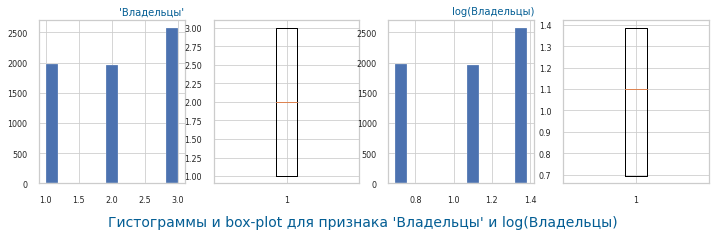

In [776]:
utils.four_plot_with_log2('Владельцы', temp_df_Train)

***Резюме по Владельцы:*** - фактически это категориальный признак с 4 значениями, но для корректной групповой обработки числовых признаков перевели его в числовые. Но на этапе построения модели скорее всего будем использовать как категориальный так как слишком мало значений признака, что делает форму распределения мало похожей на какие-нибудь известные подходящие для обработки распределения. Пропусков нет.

In [777]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('Владельцы', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= Владельцы, обработано признаков:= 11, осталось:= 10
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.12 Владение

In [778]:
# на этапе предварительного анализа были пропуски , проверим
len(df[df['Владение'].isna()])

5294

In [779]:
# посмотрим на значения в трейне
temp_df = df[df['Train']==1]
temp_df['Владение'].value_counts()

1 год и 8 месяцев      54
1 год и 2 месяца       52
1 год                  45
1 год и 5 месяцев      45
9 месяцев              45
                       ..
13 лет и 3 месяца       1
23 года и 4 месяца      1
17 лет и 11 месяцев     1
14 лет и 8 месяцев      1
10 лет и 8 месяцев      1
Name: Владение, Length: 170, dtype: int64

In [780]:
#заполняем пропуски значением nodata
df['Владение'] = df['Владение'].fillna('nodata')

def pars_num_from_tenure(row):
    d_pars_list_of_num_from_row = re.findall('\d+',row)
    if d_pars_list_of_num_from_row != []:
        if len(d_pars_list_of_num_from_row)>1:
            years = int(d_pars_list_of_num_from_row[0])
            months = int(d_pars_list_of_num_from_row[1])
            return years*12 + months
        else:
            if row.find('месяц')>-1:
                return int(d_pars_list_of_num_from_row[0])
            else:
                return int(d_pars_list_of_num_from_row[0])*12
    return None
    
df['Владение2'] = df['Владение'].apply(pars_num_from_tenure)

In [781]:
df[['Владение', 'Владение2']]

,Владение,Владение2
0,nodata,NaN
1,8 лет и 6 месяцев,102.0
2,nodata,NaN
3,4 года и 9 месяцев,57.0
4,2 года и 9 месяцев,33.0
...,...,...
8348,7 лет,84.0
8349,nodata,NaN
8350,3 года и 3 месяца,39.0
8351,6 лет и 10 месяцев,82.0


In [782]:
# посмотрим на авто со сроком владения 3 мес и меньше
df[(df['Владение2'] <= 3) \
& (df['Владение2'] >= 0)
    ][['brand',
        'name',
        'productionDate',
        'price',
        'Владение', 
        'Владение2']]

,brand,name,productionDate,price,Владение,Владение2
25,BMW,4.8is 4.8 AT (360 л.с.) 4WD,2005,830000.0,1 месяц,1.0
36,MERCEDES,350 3.5 AT (306 л.с.) 4WD,2013,2550000.0,1 месяц,1.0
574,MERCEDES,63 5.5 AT (544 л.с.) 4WD,2014,4990000.0,1 месяц,1.0
1288,BMW,30d 3.0d AT (249 л.с.) 4WD,2020,6770000.0,3 месяца,3.0
1301,AUDI,2.5d AT (180 л.с.) 4WD,2001,370000.0,2 месяца,2.0
1432,MERCEDES,450 3.0 AT (367 л.с.) 4WD,2018,6000000.0,3 месяца,3.0
1438,MERCEDES,250 d 2.1d AT (190 л.с.) 4WD,2020,12100000.0,1 месяц,1.0
1578,AUDI,2.8 AT (220 л.с.) 4WD,2011,920000.0,3 месяца,3.0
1729,MERCEDES,200 1.6 AMT (156 л.с.),2017,1590000.0,2 месяца,2.0
1782,AUDI,2.0 CVT (130 л.с.),2007,450000.0,2 месяца,2.0


In [783]:
# такие есть и в трейне и в тесте
# посмотрим на авто со сроком владения от 3 до 6 мес 
df[(df['Владение2'] <= 6) \
& (df['Владение2'] > 3)
    ][['brand',
        'name',
        'productionDate',
        'price',
        'Владение', 
        'Владение2']]

,brand,name,productionDate,price,Владение,Владение2
466,AUDI,2.0 AMT (249 л.с.) 4WD,2016,1450000.0,4 месяца,4.0
550,BMW,3.0sd 3.0d AT (286 л.с.) 4WD,2008,700000.0,5 месяцев,5.0
626,MERCEDES,350 3.5 AT (306 л.с.),2013,1650000.0,5 месяцев,5.0
773,MERCEDES,180 1.6 AMT (122 л.с.),2013,890000.0,5 месяцев,5.0
942,AUDI,2.0 AMT (211 л.с.) 4WD,2010,900000.0,6 месяцев,6.0
1078,AUDI,2.0 AMT (211 л.с.) 4WD,2009,740000.0,5 месяцев,5.0
1207,AUDI,4.2 AT (350 л.с.) 4WD,2008,920000.0,6 месяцев,6.0
1258,MERCEDES,200 1.8 AT (184 л.с.),2007,490000.0,6 месяцев,6.0
1267,AUDI,1.8 CVT (170 л.с.),2014,1110000.0,5 месяцев,5.0
1319,AUDI,4.2 AMT (450 л.с.) 4WD,2013,2050000.0,6 месяцев,6.0


In [784]:
# такие тоже есть в трейне и в тесте
# почему 3 и 6 месяцев? Потому что помоему:
# 1. срок владения авто - это хоть и условный и субъективный, 
# но какой-то показатель того сколько его юзали и сколько сможешь юзать ты.
 
# 2. срок владения опция на авто ру по желанию - можешь ставить а можешь не ставить. 
# Но те кто заполняют это видимо вкладывают в это какой-то смысл 
# и вероятно отражают в объявлении, что тоже вероятно находит отражение в цене

# 3. авто это такая покупка срок владения в которой предпалагает в нормальном большинстве случаев более 9-12 мес
# 4. таким образом если машину купили и пользовались не более 6 мес и решили продать, 
# то при покупке такого варианта надо как-то внимательно это изучить и вероятно это отразится на цене

# 5. если машину купили и пользовались не более 3 мес и решили продать, то вероятно там что-то не так и надо как-то очень внимательно это изучить
# в общем сделаем два бинарных признака владение менее 6 мес и менее 3 мес и удалим этот признак 
# так как заполнить его не представляется возможным (см.2)
def fill_month_3 (row):
    if row <=3:
        return 1
    return None
df['3month'] = df['Владение2'].apply(fill_month_3)

def fill_month_6 (row):
    if 3< row <=6:
        return 1
    return None
df['6month'] = df['Владение2'].apply(fill_month_6)

In [785]:
df[(df['3month'] == 1) \
& (df['3month'] == 1)
    ][['brand',
        'name',
        '3month',
        '6month',
        'Владение', 
        'Владение2']]

,brand,name,3month,6month,Владение,Владение2
25,BMW,4.8is 4.8 AT (360 л.с.) 4WD,1.0,NaN,1 месяц,1.0
36,MERCEDES,350 3.5 AT (306 л.с.) 4WD,1.0,NaN,1 месяц,1.0
574,MERCEDES,63 5.5 AT (544 л.с.) 4WD,1.0,NaN,1 месяц,1.0
1288,BMW,30d 3.0d AT (249 л.с.) 4WD,1.0,NaN,3 месяца,3.0
1301,AUDI,2.5d AT (180 л.с.) 4WD,1.0,NaN,2 месяца,2.0
1432,MERCEDES,450 3.0 AT (367 л.с.) 4WD,1.0,NaN,3 месяца,3.0
1438,MERCEDES,250 d 2.1d AT (190 л.с.) 4WD,1.0,NaN,1 месяц,1.0
1578,AUDI,2.8 AT (220 л.с.) 4WD,1.0,NaN,3 месяца,3.0
1729,MERCEDES,200 1.6 AMT (156 л.с.),1.0,NaN,2 месяца,2.0
1782,AUDI,2.0 CVT (130 л.с.),1.0,NaN,2 месяца,2.0


In [786]:
df[(df['6month'] == 1) \
& (df['6month'] == 1)
    ][['brand',
        'name',
        '3month',
        '6month',
        'Владение', 
        'Владение2']]

,brand,name,3month,6month,Владение,Владение2
466,AUDI,2.0 AMT (249 л.с.) 4WD,NaN,1.0,4 месяца,4.0
550,BMW,3.0sd 3.0d AT (286 л.с.) 4WD,NaN,1.0,5 месяцев,5.0
626,MERCEDES,350 3.5 AT (306 л.с.),NaN,1.0,5 месяцев,5.0
773,MERCEDES,180 1.6 AMT (122 л.с.),NaN,1.0,5 месяцев,5.0
942,AUDI,2.0 AMT (211 л.с.) 4WD,NaN,1.0,6 месяцев,6.0
1078,AUDI,2.0 AMT (211 л.с.) 4WD,NaN,1.0,5 месяцев,5.0
1207,AUDI,4.2 AT (350 л.с.) 4WD,NaN,1.0,6 месяцев,6.0
1258,MERCEDES,200 1.8 AT (184 л.с.),NaN,1.0,6 месяцев,6.0
1267,AUDI,1.8 CVT (170 л.с.),NaN,1.0,5 месяцев,5.0
1319,AUDI,4.2 AMT (450 л.с.) 4WD,NaN,1.0,6 месяцев,6.0


In [787]:
# удаляем признак
cat_cols.remove('Владение')

# добавляем два бинарных
bin_cols.append('3month')
bin_cols.append('6month')

***Резюме по Владение:*** - удаляем признак, так как слишком много пропусков. Сгенерили на его основе два бинарных признака со сроком владения не более 3 мес и до 6 мес. 

In [788]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('Владение', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= Владение, обработано признаков:= 12, осталось:= 9
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.13 ПТС

In [789]:
df = utils.auto_eda_cat_col('ПТС',
                            'тип ПТС',
                            df)

EDA по категориальному признаку:= ПТС (тип ПТС)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 2
===
КУЗ в трейне:= 2
КУЗ в тесте:= 2
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'Оригинал', 'Дубликат'}
СУЗ в тесте:=  {'Оригинал', 'Дубликат'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= set()
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===
Различий в списках уникальных значений нет.


***Резюме по ПТС:*** - категориальный признак, 2 значения, пропусков нет

In [790]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('ПТС', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= ПТС, обработано признаков:= 13, осталось:= 8
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.14 Привод

In [791]:
df = utils.auto_eda_cat_col('Привод',
                            'тип привода',
                            df)

EDA по категориальному признаку:= Привод (тип привода)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 3
===
КУЗ в трейне:= 3
КУЗ в тесте:= 3
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'задний', 'передний', 'полный'}
СУЗ в тесте:=  {'полный', 'передний', 'задний'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= set()
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===
Различий в списках уникальных значений нет.


***Резюме по Привод:*** - категориальный признак, 3 значения, пропусков нет

In [792]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('Привод', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= Привод, обработано признаков:= 14, осталось:= 7
Кол-во строк в трейне:=  6507 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.15 Руль

In [793]:
df = utils.auto_eda_cat_col('Руль',
                            'тип руля',
                            df)

EDA по категориальному признаку:= Руль (тип руля)
===
Количество уникальных значений (КУЗ)
КУЗ во всем датасете:= 2
===
КУЗ в трейне:= 2
КУЗ в тесте:= 1
===
Список уникальных значений (СУЗ)
СУЗ в трейне:= {'Левый', 'Правый'}
СУЗ в тесте:=  {'Левый'}
===
Различия в уникальных значениях (РУЗ)
РУЗ в трейне (что есть в трейне и нет в тесте):= {'Правый'}
РУЗ в тесте (что есть в тесте и нет в трейне):= set()
===

Кол-во строк критерия тип руля=='Правый' в трейне := 1     (0.02% от трейна). Рекомендую удалить.Удаление рекомендованных строк успешно проведено.


In [794]:
# удаляем признак так как теперь в нем необходимости нет, это константа на всем датасете
cat_cols.remove('Руль')

***Резюме по Руль:*** - удалили выброс на этапе анализа. Потом удалили признак.

In [795]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('Руль', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= Руль, обработано признаков:= 15, осталось:= 6
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  1
Кол-во строк в тесте:=  1671


## 4.16 mileage

In [796]:
# убедимся что признак целочисленный
df['mileage'].dtype

dtype('int64')

In [797]:
utils.describe_without_plots('mileage', df[df['Train']==1].mileage)

,mileage
кол-во строк,6506
тип значений,int64
кол-во значений,6506
кол-во NaN,0
среднее,120747
медиана,112000
мин,1
макс,999999


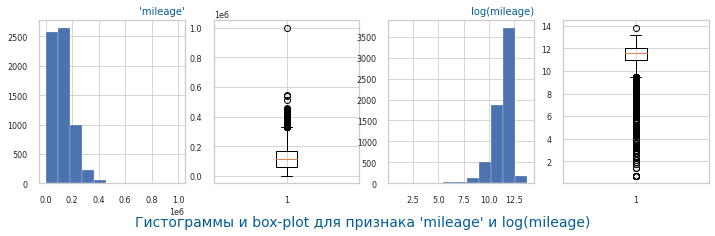

In [798]:
utils.four_plot_with_log2('mileage', df[df['Train']==1])

In [799]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('mileage',df[df['Train']==1], log = False)

,левая,правая
границы выбросов,-101483.125,329689.875
кол-во значений за границей,0.000,114.000


In [800]:
# посмотрим какие это марки с такими пробегами более 329689
df[(df['Train']==1) & (df['mileage']>329689)].brand.value_counts()

BMW         57
MERCEDES    38
AUDI        19
Name: brand, dtype: int64

In [801]:
df[(df['Train']==1) & (df['mileage']>329689)].brand.value_counts(normalize=True)

BMW         0.500000
MERCEDES    0.333333
AUDI        0.166667
Name: brand, dtype: float64

In [802]:
# посмотрим статистику на тесте по пробегу
utils.describe_without_plots('mileage', df[df['Train']==0].mileage)

,mileage
кол-во строк,1671
тип значений,int64
кол-во значений,1671
кол-во NaN,0
среднее,119725
медиана,109000
мин,1
макс,1e+06


In [803]:
# сколько авто в тесте за границей
df[(df['Train']==0) & (df['mileage']>329689)].brand.value_counts()

BMW         17
AUDI        10
MERCEDES     9
Name: brand, dtype: int64

In [804]:
df[(df['Train']==0) & (df['mileage']>329689)].brand.value_counts(normalize=True)

BMW         0.472222
AUDI        0.277778
MERCEDES    0.250000
Name: brand, dtype: float64

In [805]:
# каких-то очевидных показаний по удалению выбросов я не наблюдаю, длинные хвосты справа характерны многим распределениям.
# также не видно показаний для логарифмирования так как слева возникают выбросы
# ну чтож тогда просто проверим пробеги выше 500000 чтобы убедится что в них нет ошибок и все


In [806]:
df[(df['Train']==1) & (df['mileage']>500000)]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log,5G-TRONIC,compact,Extra,BlueEFFICIENCY,Long,Package,xDrive,sDrive,S,Brabus,GT,Edition,Kompressor,4MATIC,All-Terrain,9G-TRONIC,4x4,HYBRID,L1,L2,L3,5-speed,TDI,TFSI,CDI,BlueTEC,AMG,name2,name3,Владение2,3month,6month
1922,родстер,MERCEDES,чёрный,Рейстайлинг. \nОдин хозяин по ПТС. Оригинальны...,1.8 LTR,184 N12,бензин,999999,2008,SLK_KLASSE,200 1.8 AT (184 л.с.),2,877000.0,2008,1088341590,ROADSTER AUTOMATIC 1.8,автоматическая,1,10 лет и 11 месяцев,Оригинал,задний,Левый,1,1800.0,NaN,NaN,1800.0,7.495542,NaN,NaN,184,5.214936,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,200,131.0,NaN,NaN
2617,седан,MERCEDES,голубой,Комфорт: 8. Безопасность: 6. Обзор: 2. Мультим...,2.2 LTR,150 N12,дизель,510730,2002,E_KLASSE,220 2.2d AT (150 л.с.),4,457000.0,2003,1100047686,SEDAN AUTOMATIC 2.2,автоматическая,3,nodata,Оригинал,задний,Левый,1,2200.0,NaN,NaN,2200.0,7.696213,NaN,NaN,150,5.010635,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,220,NaN,NaN,NaN
2665,универсал 5 дв.,BMW,чёрный,Машина приехала из Германии в 2006 году с проб...,2.5 LTR,192 N12,бензин,550000,2000,5ER,525i 2.5 AT (192 л.с.),5,420000.0,2003,1099833952,WAGON_5_DOORS AUTOMATIC 2.5,автоматическая,2,nodata,Оригинал,задний,Левый,1,2500.0,NaN,NaN,NaN,NaN,2500.0,7.824046,192,5.257495,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,525i,NaN,NaN,NaN
4091,седан,MERCEDES,чёрный,Автомобиль в отличном состоянии. Без ДТП! Влож...,3.5 LTR,272 N12,бензин,542000,2005,S_KLASSE,350 3.5 AT (272 л.с.) 4WD,4,590000.0,2007,1093490366,SEDAN AUTOMATIC 3.5,автоматическая,3,2 года и 11 месяцев,Оригинал,полный,Левый,1,3500.0,NaN,NaN,3500.0,8.160518,NaN,NaN,272,5.605802,None,None,None,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Long,350,35.0,NaN,NaN


In [807]:
# посмотрим на описание авто с пробегом 999999
df.loc[1922]['description']

'Рейстайлинг. \nОдин хозяин по ПТС. Оригинальный пробег 98500 км.\n\nСостояние Очень Хорошее ! \nСделано ТО + замена масла в АКПП\nНовая резина !\n\nТехнически и юридически безупречен.\n \nКуплен в августа 2009 , \nБережная эксплуатация и своевременная замена всех расходников. \nВсе системы работают исправно. \nДва ключа. \nМосковские с номера. \nАВТОМОБИЛЬ НЕ ТРЕБУЕТ ВЛОЖЕНИЙ. \nКожанны салон\nПодушки безопасности \nABS EBD ESP \nПарктроник \nТеплый шарф.\nОхранная система \nИммобилайзер \nЦентральный замок\nДатчик света \nДатчик дождя \nОмыватель фар \nКсеноновые фары \nБортовой компьютер \nКруиз контроль \nМультируль \nЭлектропривод богажника \nЭлектрические зеркала с обогревом \nОбогрев сидений \nКлимат контроль 2-зонный \nПротивотуманные фары\nПосредникам, автосалонам и рекламным агентам - просьба не беспокоить.\nТорг.'

In [808]:
# исправим ошибку
df.loc[1922,'mileage'] = 98500

In [809]:
df[(df['Train']==0) & (df['mileage']>500000)]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Train,engineDisplacement2,engDisp_AUDI,engDisp_AUDI_log,engDisp_MERC,engDisp_MERC_log,engDisp_BMW,engDisp_BMW_log,enginePower2,enginePower2_log,5G-TRONIC,compact,Extra,BlueEFFICIENCY,Long,Package,xDrive,sDrive,S,Brabus,GT,Edition,Kompressor,4MATIC,All-Terrain,9G-TRONIC,4x4,HYBRID,L1,L2,L3,5-speed,TDI,TFSI,CDI,BlueTEC,AMG,name2,name3,Владение2,3month,6month
7642,родстер,MERCEDES,красный,"Обмен не предлагать ,по птс 394 лс",6.0 LTR,394 N12,бензин,1000000,1989,SL_KLASSE,600 6.0 AT (394 л.с.),2,NaN,1994,1054408750,ROADSTER AUTOMATIC 6.0,автоматическая,2,nodata,Дубликат,задний,Левый,0,6000.0,NaN,NaN,6000.0,8.699515,NaN,NaN,394,5.976351,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,600,NaN,NaN,NaN


In [810]:
# посмотрим на описание этог авто
df.loc[7642]['description']

'Обмен не предлагать ,по птс 394 лс'

In [811]:
# в тесте обнаружился динозавр. пробег указан с ошибкой или скручен. 
# описание хоть и есть, но скудное
# Надо будет в конце обратить внимание на этот авто и проверить назначенную цену

***Резюме по mileage:*** - признак числовой. Пропусков нет.

In [812]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('mileage', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= mileage, обработано признаков:= 16, осталось:= 5
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.17 modelDate

In [813]:
# убедимся что признак целочисленный
df['modelDate'].dtype

dtype('int64')

In [814]:
utils.describe_without_plots('modelDate', df[df['Train']==1].modelDate)

,modelDate
кол-во строк,6506
тип значений,int64
кол-во значений,6506
кол-во NaN,0
среднее,2010.2
медиана,2011
мин,1977
макс,2019


In [815]:
utils.describe_without_plots('modelDate', df[df['Train']==0].modelDate)

,modelDate
кол-во строк,1671
тип значений,int64
кол-во значений,1671
кол-во NaN,0
среднее,2009.98
медиана,2011
мин,1971
макс,2019


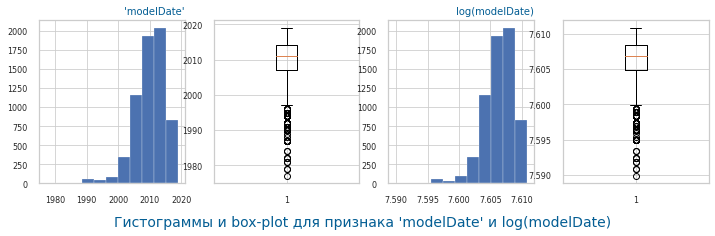

In [816]:
# посмотрим гистограммы
utils.four_plot_with_log2('modelDate', df[df['Train']==1])

In [817]:
# по виду распределения напрашивается разворот, сделаем новый признак
df['modelDate2'] = 2020 - df['modelDate']

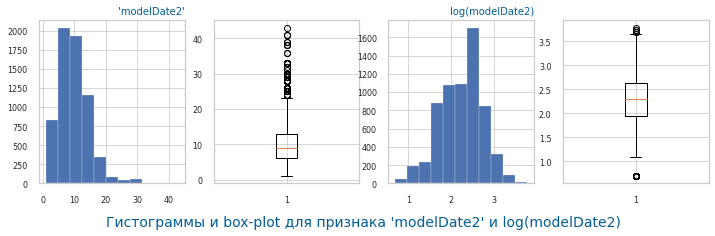

In [818]:
# посмотрим гистограммы
utils.four_plot_with_log2('modelDate2', df[df['Train']==1])

In [819]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('modelDate2',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,0.906189,3.678778
границы выбросов без логарифма,1.474874,38.597980
кол-во значений за границей,45.000000,5.000000


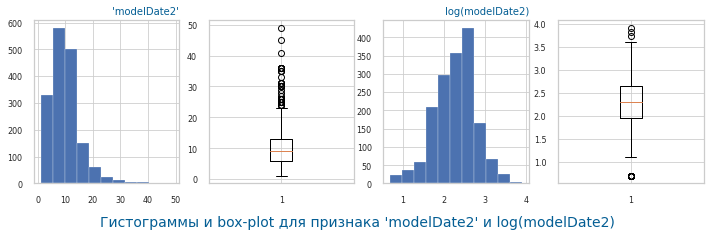

In [820]:
# посмотрим гистограммы
utils.four_plot_with_log2('modelDate2', df[df['Train']==0])

In [821]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('modelDate2',df[df['Train']==0], log = True)

,левая,правая
границы выбросов с логарифмом,0.906189,3.678778
границы выбросов без логарифма,1.474874,38.597980
кол-во значений за границей,24.000000,3.000000


In [822]:
# удалим старый признак и добавим новый
num_cols.remove('modelDate')
num_cols.append('modelDate2')

***Резюме по modelDate:*** - числовой признак. Пропусков нет. Сделали новый признак = 2020 минуc старый. Удалять выбросы после разворота не стали так как картинка на тесте лучше чем на трейне, возможно хвосты на трейне смогут как-то подтянуть качество хвостов теста. Да и как-то не очень сильно заморачивались по этому признаку так как все-таки дата производства рулит по сравнению с датой начала выпуска модели.

In [823]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('modelDate', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= modelDate, обработано признаков:= 17, осталось:= 4
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.18 productionDate

In [824]:
# убедимся что признак целочисленный
df['productionDate'].dtype

dtype('int64')

In [825]:
utils.describe_without_plots('productionDate', df[df['Train']==1].modelDate)

,productionDate
кол-во строк,6506
тип значений,int64
кол-во значений,6506
кол-во NaN,0
среднее,2010.2
медиана,2011
мин,1977
макс,2019


In [826]:
utils.describe_without_plots('productionDate', df[df['Train']==0].modelDate)

,productionDate
кол-во строк,1671
тип значений,int64
кол-во значений,1671
кол-во NaN,0
среднее,2009.98
медиана,2011
мин,1971
макс,2019


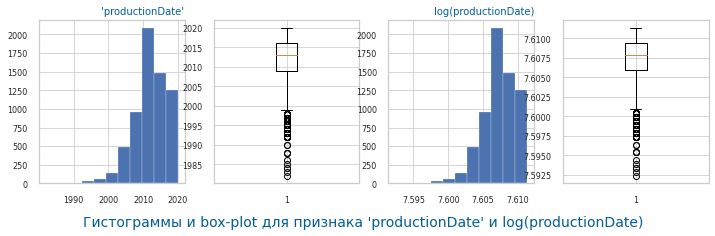

In [827]:
# посмотрим гистограммы
utils.four_plot_with_log2('productionDate', df[df['Train']==1])

In [828]:
# по виду распределения также напрашивается разворот, сделаем новый признак
df['productionDate2'] = 2020 - df['productionDate']

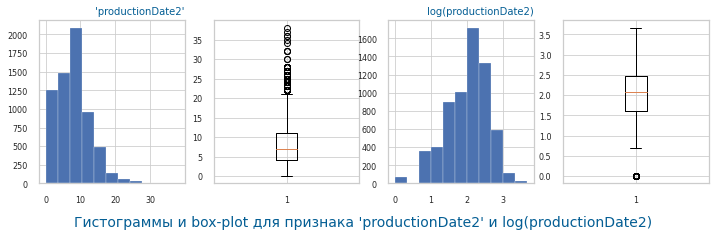

In [829]:
# посмотрим гистограммы
utils.four_plot_with_log2('productionDate2', df[df['Train']==1])

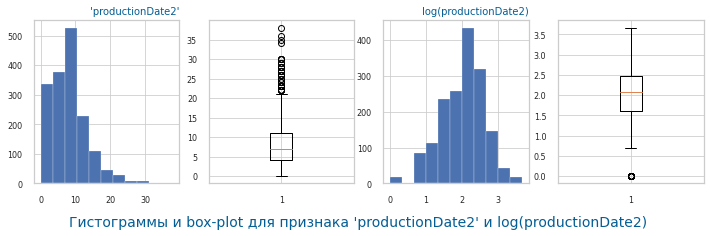

In [830]:
utils.four_plot_with_log2('productionDate2', df[df['Train']==0])

In [831]:
# удалим старый признак и добавим новый
num_cols.remove('productionDate')
num_cols.append('productionDate2')

***Резюме по productionDate:*** - - числовой признак. Пропусков нет. Сделали новый признак = 2020 минуc старый. 

In [832]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('productionDate', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= productionDate, обработано признаков:= 18, осталось:= 3
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.19 numberOfDoors

In [833]:
# убедимся что признак целочисленный
df['numberOfDoors'].dtype

dtype('int64')

In [834]:
utils.describe_without_plots('numberOfDoors', df[df['Train']==1].numberOfDoors)

,numberOfDoors
кол-во строк,6506
тип значений,int64
кол-во значений,6506
кол-во NaN,0
среднее,4.27544
медиана,4
мин,2
макс,5


In [835]:
utils.describe_without_plots('numberOfDoors', df[df['Train']==0].numberOfDoors)

,numberOfDoors
кол-во строк,1671
тип значений,int64
кол-во значений,1671
кол-во NaN,0
среднее,4.23639
медиана,4
мин,2
макс,5


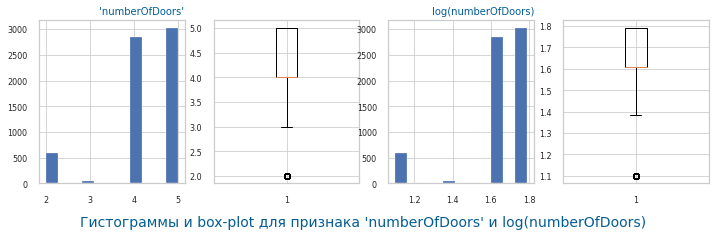

In [836]:
utils.four_plot_with_log2('numberOfDoors', df[df['Train']==1])

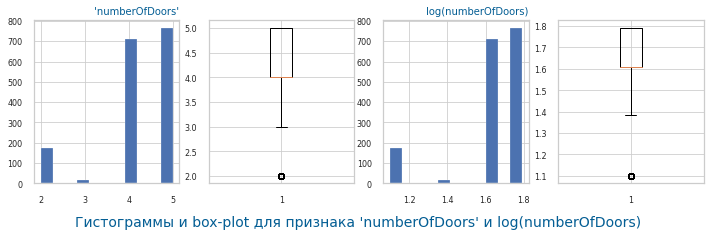

In [837]:
utils.four_plot_with_log2('numberOfDoors', df[df['Train']==0])

***Резюме по numberOfDoors:*** - фактически это категориальный признак с 4 значениями, но для корректной групповой обработки числовых признаков переведем его в числовые. Пропусков нет.

In [838]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('numberOfDoors', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= numberOfDoors, обработано признаков:= 19, осталось:= 2
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.20 price

In [839]:
utils.describe_without_plots('price', df[df['Train']==1].price)

,price
кол-во строк,6506
тип значений,float64
кол-во значений,6506
кол-во NaN,0
среднее,1.85963e+06
медиана,1.3e+06
мин,301301
макс,2.39e+07


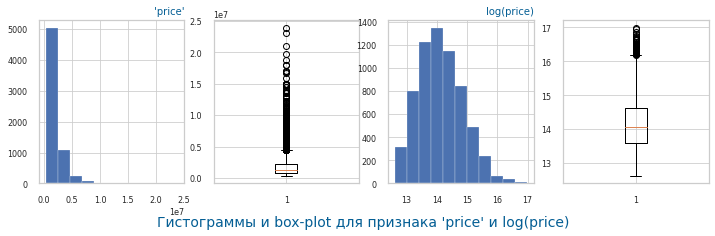

In [840]:
utils.four_plot_with_log2('price', df[df['Train']==1])


In [841]:
# распределение выглядит как логнормальное, 
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('price',df[df['Train']==1], log = True)

,левая,правая
границы выбросов с логарифмом,12.041426,1.617727e+01
границы выбросов без логарифма,169637.590932,1.060963e+07
кол-во значений за границей,0.000000,5.000000e+01


In [842]:
# создаем новый признак price_log логарифм от цены
df['price_log']=df['price'].apply(lambda x: np.log(x))

# добавим новый признак в список целевых, посмотрим что лучше обрабатывает медель потом при необходимости менее эффективный удалим
target_col.append('price_log')

***Резюме по price:*** - целевая переменная. Добавили новый признак логарифм от прайса. Пропусков нет.

In [843]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('price', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= price, обработано признаков:= 20, осталось:= 1
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


## 4.21 description

In [844]:
# Описание в трейне
temp_df = df[df['Train']==1]
temp_df['description'].iloc[2]

'Внимание! Только для клиентов AVILON Автомобили с пробегом мы предлагаем специальную кредитную программу «Гарантия минимального ежемесячного платежа».\nУсловия кредитования:\n• Первоначальный взнос от 30%.\n• Размер процентной ставки после снижения/перерасчета в конце срока кредита 9,9%.\n• Срок кредита – до 72 месяцев (до 6 лет).\n\nУвеличенная дополнительная скидка:\n1. До 150 000р. при обмене своего автомобиля на наш по системе trade-in\n2. До 100 000р. при оформлении кредита по сниженной ставки от банка-партнёра и полиса КАСКО\n\nВсе скидки и спецпредложения СУММИРУЮТСЯ!\n\nАвтомобиль Mercedes-Benz E-klasse от AVILON Автомобили с пробегом – это: \n•\tОбслуживание и предпродажная подготовка только на сертифицированных сервисных станциях с предоставлением официальной диагностики. \n•\tОбязательная юридическая проверка автомобиля, что обеспечивает полную прозрачность сервисной истории и исключает наличие финансового обременения.\n\nКупи или продай любой авто официально в AVILON Автом

In [845]:
# Описание в тесте
temp_df = df[df['Train']==0]
temp_df['description'].iloc[0]

'Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n650 Спорт

In [846]:
# запишем списки слов в описании в отдельный столбец
df['words_in_description'] = df['description'].apply(lambda x: [str(i).lower() for i in x.split()])

In [847]:
# создаем новый признак кол-во слов в описании
df['count_words_d'] = df['description'].apply(lambda x: len(x.split()))

vectorizer = CountVectorizer()
text_feat = vectorizer.fit_transform(df['description'])

# создаем новые признаки кол-во среднее кол-во токенов и их сумма в описании
df['mean_c_w'] = text_feat.mean(axis=1)
df['sum_c_w'] = text_feat.sum(axis=1)

# удаляем 'description'
cat_cols.remove('description')

# добавляем 'count_words_d', 'mean_c_w', 'sum_c_w'
num_cols.append('count_words_d')
num_cols.append('mean_c_w')
num_cols.append('sum_c_w')

In [848]:
print(*df['words_in_description'][:3], sep='===')

['авто', 'на', 'бодром', 'ходу.', 'все', 'работает', 'отлично.', 'по', 'электрике,ходовой.,акпп', 'двс', 'нареканий', 'нет..,', 'масло', 'не', 'ест.', '.!!!салон', 'ухожен.', 'на', 'запчасти', 'денег', 'не', 'жалел.', 'жидкости', 'все', 'поменял.', 'крашена', 'одна', 'дверь', 'левая', 'задняя.', 'штрафов', 'и', 'ограничений', 'нет.', '..!', 'торг', 'при', 'осмотре.', 'возможен', 'обмен', 'на', 'внедорожник', 'или', 'коммерческий', 'транспорт.']===['продажа', 'от', 'собственника,', 'второй', 'владелец,', 'птс', 'оригинал.', 'отличное', 'состояние,', 'вложений', 'не', 'требует.', 'комплект', 'новой', 'зимней', 'резины', 'nokian.', 'по', 'кузову', 'мелкие', 'притертости.', 'в', 'базе', 'бьется', 'как', '2', 'дтп,', 'т.к.', 'все', 'зарегистрировано', 'в', 'гибдд.', 'обслуживание', 'только', 'у', 'официального', 'дилера,', 'сервисная', 'книжка', 'в', 'наличии.', 'пройдено', 'то.', 'все', 'ключи.', 'эксплуатация', 'с', '2012', 'года.', 'хорошая', 'комплектация', '+', 'дополнительное', 'обору

In [849]:
# обработка слов в description
# выделяем словосочетания которые могут влиять на цену авто (дополнительный тюнинг или допопции при покупке нового авто) 
# защита картера  - crankcase protection
df['c_p_des1']= df['words_in_description'].apply(lambda x: 1 if ('защита' and 'картера') in x else 0)
bin_cols.append('c_p_des1')

# мультифункциональный руль - multifunction steering wheel
df['m_s_w_des2']= df['words_in_description'].apply(lambda x: 1 if ('мультифункциональный' and 'руль') in x else 0)
bin_cols.append('m_s_w_des2')

# датчики дождя и света - rain and light sensors
df['r_l_s_des3']= df['words_in_description'].apply(lambda x: 1 if ('датчики' and 'дождя' and 'света') in x else 0)
bin_cols.append('r_l_s_des3')

# АБС
df['abs_des4']= df['words_in_description'].apply(lambda x: 1 if ('антиблокировочная' and 'система') in x else 0)
bin_cols.append('abs_des4')

# круиз контроль - cruise control
df['c_c_des5']= df['words_in_description'].apply(lambda x: 1 if ('круиз-контроль') in x else 0)
bin_cols.append('c_c_des5')

# легкосплавные диски - alloy wheels
df['a_w_des6']= df['words_in_description'].apply(lambda x: 1 if ('легкосплавные' and 'диски') in x else 0)
bin_cols.append('a_w_des6')

# камера заднего вида - rear view camera
df['r_v_c_des7']= df['words_in_description'].apply(lambda x: 1 if ('камера' and 'видеокамера') in x else 0)
bin_cols.append('r_v_c_des7')

***Резюме по description:*** - 

In [850]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('description', df[df['Train']==1], df[df['Train']==0], 21, EDA_done_cols, old_len_train)

В результате после EDA признака:= description, обработано признаков:= 21, осталось:= 0
Кол-во строк в трейне:=  6506 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  1671


# 5. Перекрестный анализ между переменными и целевой переменной price
---
## 5.1 Оценка корреляций

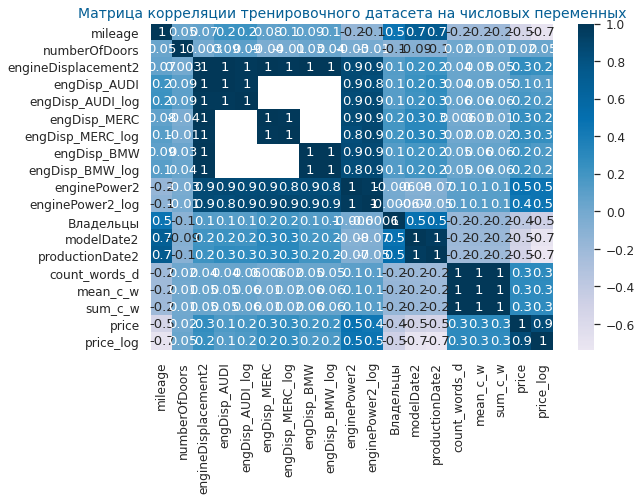

In [851]:
utils.simple_heatmap('Матрица корреляции тренировочного датасета на числовых переменных',df[df['Train']==1], num_cols+target_col, 1.1, 0, 9)

## 5.2 Значимость непрерывных переменных по ANOVA F test

In [852]:
print(num_cols)

['mileage', 'numberOfDoors', 'engineDisplacement2', 'engDisp_AUDI', 'engDisp_AUDI_log', 'engDisp_MERC', 'engDisp_MERC_log', 'engDisp_BMW', 'engDisp_BMW_log', 'enginePower2', 'enginePower2_log', 'Владельцы', 'modelDate2', 'productionDate2', 'count_words_d', 'mean_c_w', 'sum_c_w']


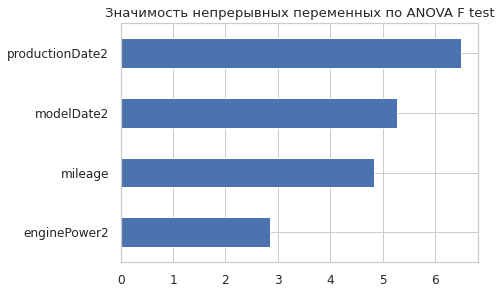

In [853]:
temp_num_cols = ['mileage', 'productionDate2','enginePower2', 'modelDate2']
temp_df = df[df['Train']==1]
imp_num = pd.Series(f_classif(temp_df[temp_num_cols], temp_df['price_log'])[0], index = temp_num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

## 5.3 Проверим статистическую значимость по всем не числовым признакам по тесту Стьюдента

In [854]:
# переведем категориальные признаки в dummies переменные
# но сначала сохраним список переменных чтобы можно было сделать список добавленных
list_cols_bef_dumm = list(df.columns)

# а также мы хотим преобразовать числовые признаки 'Владельцы' и 'engineDisplacement2'
# поэтому сохраним их дубликаты
arr_Владельцы = np.array(df['Владельцы'])

# преобразуем переменные в дамми переменные
df = pd.get_dummies(df, columns = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Владельцы', 'ПТС', 'engineDisplacement2'])

# вернем владельцев
df['Владельцы'] = arr_Владельцы 

# теперь создадим список дамми переменных
list_cols_aft_dumm = list(df.columns)
dumm_cols= list(set(list_cols_aft_dumm)-set(list_cols_bef_dumm ))

In [855]:
print(f'Мы добавили:{len(dumm_cols)} dummies featuries')

Мы добавили:90 dummies featuries


In [856]:
# Проверим, есть ли статистическая разница в распределении оценок по всем категориальным признакам, 
# с помощью теста Стьюдента. Проверим нулевую гипотезу о том, 
# что распределения price_log по различным параметрам неразличимы:
def get_stat_dif(d_column, d_df):
    cols = d_df.loc[:, d_column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(d_df.loc[d_df.loc[:, d_column] == comb[0], 'price_log'].dropna(),
                          d_df.loc[d_df.loc[:, d_column] == comb[1], 'price_log'].dropna()).pvalue
        if  ttest<= 0.05/len(combinations_all): # Учли поправку Бонферони
            return(d_column)
            break

In [857]:
stat_sign_diff_cols=[]

temp_df = df[(df['Train']==1)]
for col in bin_cols+dumm_cols:
    stat_sign_diff_cols.append(get_stat_dif(col,temp_df))
stat_sign_diff_cols = list(filter(None, stat_sign_diff_cols))

In [858]:
not_stat_sign_diff_cols=list(set(bin_cols+dumm_cols) - set(stat_sign_diff_cols))
print(f'по тесту Стьюдента {len(not_stat_sign_diff_cols)} признаков из {len(bin_cols+dumm_cols)} бинарных и dummies признаков НЕ СОДЕРЖАТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ с таргетом')
print('вот они:= ', *sorted(not_stat_sign_diff_cols))

по тесту Стьюдента 56 признаков из 126 бинарных и dummies признаков НЕ СОДЕРЖАТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ с таргетом
вот они:=  3month 4MATIC 4x4 5-speed 5G-TRONIC 6month 9G-TRONIC AMG All-Terrain BlueEFFICIENCY BlueTEC Brabus CDI Edition Extra GT HYBRID Kompressor L1 L2 L3 Long Package S  TDI TFSI bodyType_внедорожник 3 дв. bodyType_внедорожник открытый bodyType_кабриолет bodyType_купе-хардтоп bodyType_пикап двойная кабина bodyType_родстер color_белый color_голубой color_жёлтый color_коричневый color_оранжевый color_синий color_фиолетовый compact engineDisplacement2_1500.0 engineDisplacement2_1900.0 engineDisplacement2_2300.0 engineDisplacement2_3800.0 engineDisplacement2_4100.0 engineDisplacement2_4300.0 engineDisplacement2_5800.0 engineDisplacement2_5900.0 engineDisplacement2_6000.0 engineDisplacement2_6600.0 engineDisplacement2_700.0 fuelType_гибрид fuelType_электро sDrive vehicleTransmission_роботизированная xDrive


# 6. Сохранение датасета после EDA 
---
датасет сохраняется на локальной машине, чтобы потом сохранить его на каггл и использовать в основном ноутбуке

In [863]:
# сохранение датасета и названий столбцов, чтобы потом его заново не генерить
df.to_csv(PATH_to_WORKDIR+'df2.csv', index=False)

In [864]:
# также сохраняем названия столбцов по типам
df_cols = pd.DataFrame()
df_cols['cat_cols']=[','.join(cat_cols)]
df_cols['num_cols']=[','.join(num_cols)]
df_cols['servis_cols']=[','.join(servis_cols)]
df_cols['bin_cols']=[','.join(bin_cols)]
df_cols['target_col']=[','.join(target_col)]
df_cols.to_csv(PATH_to_WORKDIR+'df2_cols.csv', index=False)

In [228]:
from importlib import reload
reload(utils)

<module 'utils_module06022021_without_GPU' from '/home/aleks/GitHub/skillfactory_rds/module_8/utils_module06022021_without_GPU.py'>